# Attention Mechanism (Graded)

Welcome to your Attention (required) programming assignment! You will build a **Machine Translation** model using Attention. You will be using [Bilingual Sentence Pairs](https://www.kaggle.com/datasets/alincijov/bilingual-sentence-pairs) dataset which contains 81 distinct languages. The dataset is structured in such a way that there's an english translation against each sentence in a specific language.

Your goal is to select a dataset of your liking and build a machine translation model to translate it into english!

**Instructions:**
* Do not modify any of the codes.
* Only write code when prompted. For example in some sections you will find the following,
```
# YOUR CODE GOES HERE
# YOUR CODE STARTS HERE
# TODO
```
Only modify those sections of the code.

**You will learn:**
* Data preprocessing for Machine Translation problem. Cleaning the data, tokenizing it, and padding sequences to a uniform length.
* Incorporating attention mechanism into the seq2seq model. This mechanism allows the decoder to focus on relevant parts of the input sequence when generating the output sequence, improving translation accuracy.
* Build a robust Machine Translation model.
* Inference using trained model to make predictions.

# Machine Translation using Seq2Seq Attention Mechanism

<img src="assets/attention-1.png" width=500>

1. **User Input:**
  * The user enters an English sentence, which serves as the input to the model.

2. **Encoder:**

  * The encoder processes the English sentence, converting it into a numerical representation (embeddings). This involves breaking down the sentence into individual words or tokens and representing each token as a dense vector.
  * The encoder typically uses a recurrent neural network (RNN) or a transformer to capture the sequential nature of the input. RNNs process the input sequence one word at a time, maintaining a hidden state that stores information about the previously seen words.

3. **Seq2Seq Model:**

  * This is the core of the model that connects the encoder and decoder.
  The Seq2Seq model processes the encoded English sentence and passes it to the decoder.
  * It acts as a bridge between the two components, ensuring that the information from the encoder is effectively transmitted to the decoder.

4. **Decoder:**

  * The decoder generates the Hindi sentence, one word at a time. It uses the encoded English sentence as context and its own previous outputs to predict the next word.
  * The decoder often employs an attention mechanism to focus on relevant parts of the encoded English sentence while generating the Hindi output.
  * This allows the decoder to align the English words with their corresponding Hindi translations, ensuring that the generated Hindi sentence is coherent and accurate.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import random
import os
# from helpers import *
# from tests import *

from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
tqdm.pandas()

In [2]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import seaborn as sns

class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()

    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))

        self.vocab = sorted(self.vocab)

        self.word2idx['<pad>'] = 0
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1

        for word, index in self.word2idx.items():
            self.idx2word[index] = word

def preprocess_lines(lines):
    '''
    Preprocesses the given list of sentence pairs.

    args:
      lines: list of tuples, each containing (source_sentence, target_sentence).

    returns:
      Preprocessed list of sentence pairs.
    '''
    prep_lines = [
        [preprocess(i, sp_tokens=False),
         preprocess(j, sp_tokens=True)]
        for i, j in lines
    ]

    return prep_lines

def create_language_indices(prep_lines):
    '''
    Creates language indices for input and target languages.

    args:
      prep_lines: list of preprocessed sentence pairs.

    returns:
      inp_lang: LanguageIndex object for the input language.
      tgt_lang: LanguageIndex object for the target language.
    '''
    inp_lang = LanguageIndex(en for en, ma in prep_lines)
    tgt_lang = LanguageIndex(ma for en, ma in prep_lines)

    return inp_lang, tgt_lang

def detokenize(tokens, idx2word):
    text = ""
    for t in tokens:
        if 'tensorflow' in str(type(tokens)):
            text += idx2word[t.numpy()] + ' '
        else:
            text += idx2word[t] + ' '
    text = text.replace(' <pad>', '')
    text = text.replace('<start>', '')
    text = text.replace('<end>', '')
    return text.strip()

# Function to plot model metrics
def plot_metrics(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Function to plot the attention weights
def plot_attention_weights(attention, sentence, idx=None, annotate=True):
    if idx:
        attention = attention[idx]
    fig, ax = plt.subplots(figsize=(28, 26))
    sns.heatmap(attention, annot=annotate, cmap='viridis', ax=ax, fmt="")  # Ensure formatting is consistent

    # Set ticks in the middle of each cell
    ax.set_xticks([x + 0.5 for x in range(len(sentence))])  # Shift x-ticks to the middle of the cells
    ax.set_yticks([y + 0.5 for y in range(len(sentence))])  # Shift y-ticks to the middle of the cells

    ax.set_xticklabels(sentence, rotation=90)  # Center labels horizontally and vertically
    ax.set_yticklabels(sentence, rotation=360)  # No rotation needed, center labels

    ax.set_xlabel('Attention for each word in input')
    ax.set_ylabel('Attention by each word in input')
    plt.show()

# Function to preprocess the input text
def preprocess_input_text(text, tokenizer, max_len):
    # Tokenize and convert the input text to sequences
    sequences = tokenizer.texts_to_sequences([text])
    # Pad the sequence to ensure it has the same length as the training data
    padded_sequence = pad_sequences(sequences, maxlen=max_len)
    return padded_sequence


# Predict on new sentences:
def predict_seq2seq(encoder, decoder, src_tokens, tgt_vocab, num_steps):
    enc_X = tf.expand_dims(src_tokens, axis=0)
    mask = tf.expand_dims(enc_X != 0, 1)

    enc_outputs, enc_state = encoder(enc_X, training=False)
    dec_state = enc_state
    
    dec_X = tf.expand_dims(tf.constant([tgt_vocab.word2idx['<start>']]), axis=0)
    output_seq = []
    attention_weights = []
    for _ in range(num_steps):
        Y, dec_state, att_wgts = decoder(
            dec_X, enc_outputs, dec_state, mask,training=False)
        dec_X = tf.argmax(Y, axis=2)
        pred = tf.squeeze(dec_X, axis=0)
        if pred[0].numpy() == tgt_vocab.word2idx['<end>']:
            break
        output_seq.append(pred[0].numpy())
        attention_weights.append(tf.squeeze(att_wgts, 0))
        
    attention_weights = tf.squeeze(tf.stack(attention_weights, axis=0), 1)
    return detokenize(output_seq, tgt_vocab.idx2word), attention_weights




In [3]:
import tensorflow as tf
# from helpers import LanguageIndex

def validate_data_loader(
    data_loader_func, 
    path, 
    batch_size, 
    samples=None, 
    max_len=None, 
    reverse=False
):
    """
    Validates the data_loader function to ensure that it returns the expected outputs.
    
    PARAMETERS
    ----------
    data_loader_func : function
        The data_loader function to validate.
    path : str
        Path to the translation file.
    batch_size : int
        The batch size for training.
    samples : int, optional
        Number of samples to load. If None, all samples are loaded.
    max_len : int, optional
        Maximum length of sequences. If None, the actual maximum length of the dataset is used.
    reverse : bool, optional
        Whether to reverse input-target pairs.
        
    Raises
    ------
    ValueError
        If any aspect of the data_loader output is incorrect.
    """
    try:
        # Load the data using the provided data_loader function
        train_dataset, test_dataset, inp_lang, tgt_lang, max_length_inp, max_length_tgt = data_loader_func(
            path, batch_size, max_len, reverse
        )
    except Exception as e:
        raise ValueError(f"Data loader failed to execute: {str(e)}")
    
    # Check if train_dataset and test_dataset are tf.data.Dataset instances
    if not isinstance(train_dataset, tf.data.Dataset):
        raise ValueError("train_dataset is not an instance of tf.data.Dataset")
    
    if not isinstance(test_dataset, tf.data.Dataset):
        raise ValueError("test_dataset is not an instance of tf.data.Dataset")
    
    # Check if inp_lang and tgt_lang are instances of LanguageIndex
    if not isinstance(inp_lang, LanguageIndex):
        raise ValueError("inp_lang is not an instance of LanguageIndex")
    
    if not isinstance(tgt_lang, LanguageIndex):
        raise ValueError("tgt_lang is not an instance of LanguageIndex")
    
    # Check if input vocabulary size and target vocabulary size are positive
    if len(inp_lang.word2idx) <= 0:
        raise ValueError("Input language vocabulary size must be greater than 0")
    
    if len(tgt_lang.word2idx) <= 0:
        raise ValueError("Target language vocabulary size must be greater than 0")
    
    # Check if max_length_inp and max_length_tgt are positive integers
    if max_length_inp <= 0:
        raise ValueError(f"max_length_inp must be positive, got {max_length_inp}")
    
    if max_length_tgt <= 0:
        raise ValueError(f"max_length_tgt must be positive, got {max_length_tgt}")
    
    # Validate that datasets have appropriate batch sizes
    train_batch_count = len(list(train_dataset))
    test_batch_count = len(list(test_dataset))
    
    if train_batch_count <= 0:
        raise ValueError("Training dataset has no batches, check the batch size or data loading process")
    
    if test_batch_count <= 0:
        raise ValueError("Test dataset has no batches, check the batch size or data loading process")

    # Validate individual data batches for input-output shapes
    for batch_inp, batch_tgt in train_dataset.take(1):
        if batch_inp.shape[1] != max_length_inp:
            raise ValueError(f"Input tensor shape mismatch. Expected max_length_inp {max_length_inp}, got {batch_inp.shape[1]}")
        
        if batch_tgt.shape[1] != max_length_tgt:
            raise ValueError(f"Target tensor shape mismatch. Expected max_length_tgt {max_length_tgt}, got {batch_tgt.shape[1]}")
    
    print("Data loader is working correctly.")



def validate_encoder(encoder, vocab_inp_size, embed_dim=64, units=50):
  """
  Checks if the encoder is properly defined by creating a test input 
  and verifying the output shapes.

  Args:
    encoder: The encoder instance to check.
    vocab_inp_size: The size of the input vocabulary.
    embed_dim: The embedding dimension. Defaults to 64.
    units: The number of units in the LSTM layer. Defaults to 50.

  Raises:
    ValueError: If the encoder output shapes do not match the expected shapes.
  """
  # Create a test input
  test_input = tf.constant([[1, 2, 3, 0, 0]])  # Example input sequence

  # Call the encoder
  enc_outputs, enc_state = encoder(test_input)

  # Check output shapes
  expected_enc_outputs_shape = (1, 5, units)  
  expected_enc_state_shape = (1, units)  

  if not enc_outputs.shape.as_list() == list(expected_enc_outputs_shape):
    raise ValueError(f"Encoder output shape mismatch. Expected: {expected_enc_outputs_shape}, Got: {enc_outputs.shape}")
  if not enc_state[-1].shape.as_list() == list(expected_enc_state_shape):
    raise ValueError(f"Encoder state shape mismatch. Expected: {expected_enc_state_shape}, Got: {enc_state[-1].shape}")

  print("Encoder checks passed!") # If no errors are raised, the check has passed



def validate_attention(attention):
    """
    Validates if an attention layer is defined appropriately.
    
    PARAMETERS
    ----------
    attention : object
        The attention object to validate. It should have attributes like `W_q`, `W_k`, and `W_v`.
    
    Raises
    ------
    ValueError
        If any attribute is missing or dimensions do not match.
    """
    required_attributes = ['W_q', 'W_k', 'W_v']

    # Check if the required attributes are present in the attention mechanism
    for attr in required_attributes:
        if not hasattr(attention, attr):
            raise ValueError(f"Attention mechanism is missing the required attribute '{attr}'")
    
    # Validate the units of the dense layers
    try:
        units = attention.W_q.units
        if units <= 0:
            raise ValueError(f"The number of units in W_q must be positive, got {units}")
        if attention.W_k.units != units:
            raise ValueError(f"W_k units ({attention.W_k.units}) do not match W_q units ({units})")
        if attention.W_v.units != 1:
            raise ValueError(f"W_v units should be 1 for scalar scores, got {attention.W_v.units}")
    except AttributeError as e:
        raise ValueError(f"Attention's dense layers are not defined properly: {str(e)}")
    
    print("Attention mechanism is defined correctly.")

def validate_decoder(decoder, vocab_tgt_size, embed_dim=64, units=50):
  """
  Checks if the decoder is properly defined by creating test inputs
  and verifying the output shapes.

  Args:
    decoder: The decoder instance to check.
    vocab_tgt_size: The size of the target vocabulary.
    embed_dim: The embedding dimension. Defaults to 64.
    units: The number of units in the LSTM layer. Defaults to 50.

  Raises:
    ValueError: If the decoder output shapes do not match the expected shapes.
  """
  # Create test inputs
  test_input = tf.constant([[1, 2, 0, 0]])  # Example target sequence
  test_enc_outputs = tf.random.normal((1, 5, units))  # Example encoder outputs
  test_enc_state = [tf.random.normal((1, units))]  # Example encoder state

  # Call the decoder
  dec_output, dec_state, att_wgts = decoder(
      test_input, test_enc_outputs, test_enc_state)

  # Check output shapes
  expected_dec_output_shape = (1, 4, vocab_tgt_size)
  expected_dec_state_shape = (1, units)
  expected_att_wgts_shape = (1, 4, 5)

  if not dec_output.shape.as_list() == list(expected_dec_output_shape):
    raise ValueError(
        f"Decoder output shape mismatch. Expected: {expected_dec_output_shape}, Got: {dec_output.shape}")
  if not dec_state[-1].shape.as_list() == list(expected_dec_state_shape):
    raise ValueError(
        f"Decoder state shape mismatch. Expected: {expected_dec_state_shape}, Got: {dec_state[-1].shape}")
  if not att_wgts.shape.as_list() == list(expected_att_wgts_shape):
    raise ValueError(
        f"Attention weights shape mismatch. Expected: {expected_att_wgts_shape}, Got: {att_wgts.shape}")

  print("Decoder checks passed!") # If no errors are raised, the check has passed

def test_model_loss(test_loss, min_val_loss=0.095):
  """Tests if the model achieved at least the minimum test loss.

  Args:
      test_accuracy: The accuracy of the model on the test data.
      min_val_loss: The minimum required validation loss.

  Raises:
      AssertionError if the minimum validation loss is not met.
  """
  assert test_loss <= min_val_loss, f"Model did not achieve minimum test loss of {min_val_loss:.2f}, achieved {test_loss:.2f}"


**Before we get started:**

Download any .txt data from here: [Bilingual Sentence Pairs](https://www.kaggle.com/datasets/alincijov/bilingual-sentence-pairs)

In [4]:
!curl -L -o ~/Downloads/bilingual-sentence-pairs.zip\
  https://www.kaggle.com/api/v1/datasets/download/alincijov/bilingual-sentence-pairs

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0 99.6M    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (23) Failure writing output to destination


In [5]:
# TODO

# Load dataset
dataset_path = "mtdata/hin.txt"  #TODO: Path to your dataset


In [6]:
# TODO

with open(dataset_path, 'r', encoding='utf-8') as f:

    #TODO: Check the length of the dataset
    lines = f.readlines()
    num_lines = len(lines)

    print(f"Length of the dataset: {num_lines}")

FileNotFoundError: [Errno 2] No such file or directory: 'mtdata/hin.txt'

In [ ]:
# Printing a few lines from the dataset

print("Sample lines:")
for i in range(5):
    print(lines[i].strip())

Sample lines:
Wow!	वाह!	CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #6179147 (fastrizwaan)
Help!	बचाओ!	CC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #459377 (minshirui)
Jump.	उछलो.	CC-BY 2.0 (France) Attribution: tatoeba.org #631038 (Shishir) & #6179121 (fastrizwaan)
Jump.	कूदो.	CC-BY 2.0 (France) Attribution: tatoeba.org #631038 (Shishir) & #6179122 (fastrizwaan)
Jump.	छलांग.	CC-BY 2.0 (France) Attribution: tatoeba.org #631038 (Shishir) & #6179123 (fastrizwaan)


# Data Preparation

The data is prepared by carrying out the following steps:


1. **Data cleaning:** Lowercasing, removing punctuations, excluding special characters etc.
2. **Tokenizing and Padding:** Padding input and target tensors to a uniform length.
3. **Train/Test Split:** Create `tf.data.Dataset` objects for training and testing. Also shuffle and create batches for efficient training.



## Data Cleaning

* **Lowercasing:** Converting all text to lowercase ensures that words are treated the same regardless of their capitalization.
* **Removing Punctuations:** Punctuations can introduce noise and are often not relevant to the meaning of the text.
* **Removing Special Characters/aposrophes:** Removing special characters and unnecessary symbols eliminates additional noise.
* **Removing Extra Spaces:** Removing extra spaces and standardizing the spacing ensures that the text is uniformly formatted.
* **Adding Special Tokens:** Adding special tokens such as <start> and <end> helps the model identify the beginning and end of sequences, which is important for sequence-to-sequence tasks like machine translation.

In [ ]:
# TODO

def preprocess(sent, sp_tokens=False):
    '''
    Performs all text preprocessing steps such as removing
    unncecessary characters, adding special tokens, etc.

    sent (str): sentence to preprocess
    exclude (str): characters to exclude (like punctuations)
    sp_tokens (bool): If True, special tokens '<start>' and '<end>'
                      will be added. Default False.

    reuturns (str): preprocessed sentence
    '''


    exclude = set(string.punctuation)  # TODO: create a set of punctuations to exclude(eg: !@#$%)
    sent = sent.lower()  #TODO: Lower case all the words inside 'sent'
    sent = sent.replace("'","") #TODO: Remove aposrophes ''
    sent = ''.join(char for char in sent if char not in exclude)     #TODO: Get rid of all the punctuations
    sent = sent.strip()      #TODO: Remove leading and trailing spaces
    sent = ''.join(sent.split())     #TODO: Replace multiple spaces with a single space

    if sp_tokens:
        sent = '<start> ' + sent + ' <end>' #TODO: Add '<start>' and '<end>' tokens to the sentence

    return sent

def preprocess_lines(lines):
    '''
    Preprocesses the given list of sentence pairs.

    args:
      lines: list of tuples, each containing (source_sentence, target_sentence).

    returns:
      Preprocessed list of sentence pairs.
    '''
    prep_lines = [
        [preprocess(i, sp_tokens=False),
         preprocess(j, sp_tokens=True)]
        for i, j in lines
    ]

    return prep_lines


In [ ]:
#TODO

def load_dataset(path, reverse=False):
    '''
    Loads and optionally reverses the language pairs inside the dataset.

    args:
      path: str, path to the translation file.
      reverse: bool, optional, if True, reverse the language pairs. Default False.

    returns:
      lines (list): list of sentence pairs.
    '''
    with open(path, 'r', encoding='utf-8') as f:
        lines = [line.strip().split('\t')[:2] for line in f.readlines()]
    # lines = [line.strip().split('\t') for line in f.readlines()]  #TODO: Create a list of lists of language pairs

    if reverse:
        lines = [[tgt, src] for src, tgt in lines] #TODO: Reverse the positions of language pairs

    return lines

In [ ]:
ll = load_dataset(dataset_path, reverse=False)

ll[:10]

[['Wow!', 'वाह!'],
 ['Help!', 'बचाओ!'],
 ['Jump.', 'उछलो.'],
 ['Jump.', 'कूदो.'],
 ['Jump.', 'छलांग.'],
 ['Hello!', 'नमस्ते।'],
 ['Hello!', 'नमस्कार।'],
 ['Cheers!', 'वाह-वाह!'],
 ['Cheers!', 'चियर्स!'],
 ['Got it?', 'समझे कि नहीं?']]

**Expected lines to return:**

  ```
  [['Wow!', 'वाह!'], ['Help!', 'बचाओ!'], ['Jump.', 'उछलो.'] ...... ]

  ```

***Note:*** *The second value inside the list of lists can be any chosen language that you selected for this task*

## Tokenizing and Padding

* **Tokenization:** Tokenization is essential to convert text data into a numerical format that can be processed by machine learning models.
* **Padding:** Padding ensures that all sequences in a batch have the same length, which is a requirement for many deep learning models, especially those using recurrent neural networks or transformers.

In [ ]:

def create_tensors(prep_lines, inp_lang, tgt_lang):
    '''
    Converts preprocessed sentences into input and target tensors.

    args:
      prep_lines: list of preprocessed sentence pairs.
      inp_lang: LanguageIndex object for the input language.
      tgt_lang: LanguageIndex object for the target language.

    returns:
      input_tensor: list of input tensors.
      target_tensor: list of target tensors.
    '''
    input_tensor = [[inp_lang.word2idx[w] for w in inp.split(' ')]
                    for inp, tgt in prep_lines]

    target_tensor = [[tgt_lang.word2idx[w] for w in tgt.split(' ')]
                     for inp, tgt in prep_lines]

    return input_tensor, target_tensor

#TODO
def pad_tensors(input_tensor, target_tensor, max_len=None):
    '''
    Pads input and target tensors to the specified max length.

    args:
      input_tensor: list of input tensors.
      target_tensor: list of target tensors.
      max_len: int, optional, maximum length for padding. Default None.

    returns:
      input_tensor: padded input tensor.
      target_tensor: padded target tensor.
      max_length_inp: int, maximum length of input tensor.
      max_length_tgt: int, maximum length of target tensor.
    '''
    if max_len:
        input_tensor = [seq[:max_len] for seq in input_tensor]      #TODO: Create a list of lists of input_tensors with sequences <= max_len
        target_tensor = [seq[:max_len] for seq in target_tensor]      #TODO: Create a list of lists of target_tensors with sequences <= max_len
        max_length_inp = max_length_tgt = max_len
    else:
        max_length_inp = max(len(seq) for seq in input_tensor)    #TODO: Get the length of the longest sequence in the input_tensor.
        max_length_tgt = max(len(seq) for seq in target_tensor)    #TODO: Get the length of the longest sequence in the target_tensor.

    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, maxlen=max_length_inp, padding='post')  #TODO: pad input_tensor sequences using keras 'pad_sequences' method.

    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, maxlen=max_length_tgt, padding='post') #TODO: pad target_tensor sequences using keras 'pad_sequences' method.

    return input_tensor, target_tensor, max_length_inp, max_length_tgt





## Train/Test Split

In [ ]:
#TODO
def split_dataset(input_tensor, target_tensor, batch_size):
    '''
    Splits the dataset into training and validation sets.

    args:
      input_tensor: padded input tensor.
      target_tensor: padded target tensor.
      batch_size: int, batch size for training and validation sets.

    returns:
      train_dataset: tf.data.Dataset for training.
      test_dataset: tf.data.Dataset for validation.
    '''
    input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split( #TODO: Split the input and target tensor into train and test sets
        input_tensor,
        target_tensor,
        test_size=0.1,
        random_state=42)
    train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train))
    test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val))

    train_dataset = train_dataset.shuffle(len(input_tensor_train)).batch(batch_size) #TODO: Create a TF dataset object, shuffle it and divide it into batches

    test_dataset = test_dataset.shuffle(len(input_tensor_val)).batch(batch_size) #TODO: Create a TF dataset object, shuffle it and divide it into batches

    return train_dataset, test_dataset


In [ ]:

def data_loader(path, batch_size, max_len=None, reverse=False):
    '''
    Combines all the above methods to load and preprocess the dataset.

    args:

      path: str, path to the translation file.
      batch_size: int, batch size for training and validation sets.
      max_len: int, optional, maximum length for padding. Default None.
      reverse: bool, optional, if True, reverse the language pairs. Default False.

    returns:

      train_dataset: tf.data.Dataset for training.
      test_dataset: tf.data.Dataset for validation.
      inp_lang: LanguageIndex object for input language.
      tgt_lang: LanguageIndex object for target language.
      max_length_inp: int, maximum length of input tensor.
      max_length_tgt: int, maximum length of target tensor.
    '''
    lines = load_dataset(path, reverse)   #TODO: Load the dataset
    prep_lines = preprocess_lines(lines)   #TODO: Preprocess the input sequences
    inp_lang, tgt_lang = create_language_indices(prep_lines)
    input_tensor, target_tensor = create_tensors(prep_lines, inp_lang, tgt_lang)
    input_tensor, target_tensor, max_length_inp, max_length_tgt = pad_tensors(input_tensor, target_tensor, max_len)   #TODO: Pad the input and target tensors

    train_dataset, test_dataset = split_dataset(input_tensor, target_tensor, batch_size)

    return train_dataset, test_dataset, inp_lang, tgt_lang, max_length_inp, max_length_tgt


# Model training and Evaluation

### Encoder Network

The encoder is responsible for processing the input sequence (the English sentence) and transforming it into a fixed-length vector representation. This representation, often called the "context vector", captures the essence of the input sequence and is passed to the decoder.



In [ ]:
#TODO

# Encoder
class Encoder(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, vocab_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero=True)    #TODO: Add an Embedding layer with mask set to True
        self.rnn = tf.keras.layers.LSTM(units, return_sequences=True, return_state=True) #TODO: Add an LSTM layer with return_state and sequences set to True

    def call(self, x):
        # x => (batch_size, max_len)
        x = self.embedding(x)  #TODO: Input Embedding dim (batch_size, s, embed_dim)
        enc_outputs = self.rnn(x)  #TODO: RNN encoder inputs
        return enc_outputs[0], enc_outputs[1:]


### Attention

We perform the Additive attention, also known as Bahdanau attention, was introduced by Dzmitry Bahdanau, Kyunghyun Cho, and Yoshua Bengio in their 2015 paper, "Neural Machine Translation by Jointly Learning to Align and Translate."

Additive attention allows the model to automatically learn which parts of the input sequence are most relevant to each output word during decoding. The name "additive" comes from the fact that it combines (adds) the decoder's hidden state and the encoder's hidden states to compute attention scores.

the process of calculating attention weights and using them to create a context vector that captures the relevant information from the source sequence for generating the target sequence is as follows:

$$
e_{ij} = v_a^T \tanh(W_a s_{i-1} + U_a h_j)
$$

where,
* $eij$ is the alignment score between the i-th element of the source sequence and the j-th element of the target sequence.
* $va, Wa$, and Ua are matrices used to calculate the alignment score.
* $s_i-1$ is the hidden state of the decoder at the previous time step.
*$hj$ is the hidden state of the encoder at the j-th time step.


$$
a_{ij} = \frac{exp(e_{ij})}{\sum_{k=1}^{T_x} exp(e_{ik})}
$$

where,
* $aij$ is the attention weight for the i-th element of the source sequence and the j-th element of the target sequence.
* The equation calculates the attention weight by normalizing the alignment scores using the softmax function.


$$
c_i = \sum_{j=1}^{T_x} \alpha_{ij} h_j
$$

where,
* $ci$ is the context vector at the i-th time step of the decoder.
* The equation calculates the context vector by taking a weighted sum of the encoder hidden states, where the weights are the attention weights.

In [ ]:

#TODO
class Attention(tf.keras.layers.Layer):

    def __init__(self, units):
        super().__init__()
        self.W_q = tf.keras.layers.Dense(units)  #TODO: define query(dense layer)
        self.W_k = tf.keras.layers.Dense(units)  #TODO: define key(dense layer)
        self.W_v = tf.keras.layers.Dense(1)      #TODO: define value(dense layer)


    def call(self, query, key, value, mask=None):
        query, key = self.W_q(query), self.W_k(key)
        # query => (batch_size, t, units)
        # key => (batch_size, s, units)

        score = self.W_v(
            tf.math.tanh(
                tf.expand_dims(query, 2) + tf.expand_dims(key, 1)
            )
        )
        score = tf.squeeze(score, -1)
        # score => (batch_size, t, s)

        if mask is not None:
            score = tf.where(mask, score, -1e6)

        attention_weights = tf.nn.softmax(score, axis=-1)  #TODO: attention weights shape (batch_size, t, s)

        context = tf.matmul(attention_weights, value)      #TODO: context vector shape (batch_size, t, units)

        return context, attention_weights

### Decoder Network

The decoder is responsible for generating the target sequence (language you chose) word by word, using the context vector produced by the encoder and its own internal state.

In [ ]:
#TODO
class Decoder(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, vocab_size):
        super().__init__()

        # Embedding layer to convert tokens to vectors
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, embed_dim, mask_zero=True)

        # RNN layer
        self.rnn = tf.keras.layers.LSTM(
            units, return_sequences=True, return_state=True)

        # Attention layer
        self.attention = Attention(units)

        # Final layer to output logits, we can use
        # argmax to know which output token is predicted.
        self.fc = tf.keras.layers.Dense(vocab_size)


    def call(self, x, enc_outputs, state, mask=None):
        x = self.embedding(x)  #TODO: Add an Embedding layer with x as input
        # x => (batch_size, t, embed_dim)

        dec_outputs = self.rnn(x, initial_state=state)  #TODO: Add an rnn layer with initial_state state to state
        output = dec_outputs[0]
        state = dec_outputs[1:]
        # output   => (batch_size, t, units)
        # state[i] => (batch_size, s, units)

        context_vector, attention_weights = self.attention(
            query=output,
            key=enc_outputs,
            value=enc_outputs,
            mask=mask
        )
        # context_vector => (batch_size, t, units)
        # attention_weights => (batch_size, t, s)

        context_rnn_output = tf.concat(
            [context_vector, output], axis=-1)
        # context_rnn_output => (batch_size, t, 2*units)

        pred = self.fc(context_rnn_output)
        # pred => (batch_size, t, vocab_size)

        return pred, state, attention_weights

## Custom Loss Function

the following custom loss function calculates the cross-entropy loss between the predicted and actual target tokens, but it ignores the padding tokens to avoid penalizing the model for predicting them. This helps the model focus on learning the actual translation task.

In [ ]:
# Custom loss function:
def loss_fn(y_true, y_pred):
    # y_true => (batch_size, max_len)
    # y_pred => (batch_size, max_len, vocab_size)

    mask = tf.cast(y_true != 0, tf.float32)

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    # masking the padding tokens
    loss = tf.reduce_sum(loss * mask)

    print(f"Loss: {loss.numpy()}")

    
    return loss

## Model Training

 We're going to orchestrate the entire training process of the machine translation model, from data preparation to model updates and performance tracking.

 You need to acheive minimum **loss of 0.095** to pass this test.

In [ ]:
#TODO

# TODO: Define Hyperparameters
BATCH_SIZE = 256 #Minimum 64
EMBEDDING_DIM = 1024  #Minimum 50
UNITS = 512 #Minimum 50
NUM_EPOCHS = 50
# NUM_EPOCHS =

validate_data_loader(data_loader, path=dataset_path, batch_size=BATCH_SIZE)

#TODO: Load data using Dataloader
train_dataset, test_dataset, inp_lang, tgt_lang, max_length_inp, max_length_tgt = data_loader(dataset_path, BATCH_SIZE)

vocab_inp_size = len(inp_lang.word2idx) #Vocab size of English
vocab_tgt_size = len(tgt_lang.word2idx) #Vicab size of language you chose

#TODO: Load Adam optimizer
trainer = tf.keras.optimizers.Adam()

# Creating instances of encoder and decoder
encoder = Encoder(EMBEDDING_DIM, UNITS, vocab_inp_size)
validate_encoder(encoder, vocab_inp_size, embed_dim=64, units=512)

decoder = Decoder(EMBEDDING_DIM, UNITS, vocab_tgt_size)

#Storing loss at each epoch to plot later
history = {
'loss': []
}

for epoch in range(NUM_EPOCHS):
    total_loss = 0.

    with tqdm(total=len(train_dataset)) as pbar:
        for batch, (x, y) in enumerate(train_dataset):
            inp_mask = tf.expand_dims(x != 0, axis=1)
            tgt_mask = tf.cast(y != 0, tf.float32)

            with tf.GradientTape() as tape:
                # loss = tf.constant(0.0)
                enc_outputs, enc_states = encoder(x)
                dec_states = enc_states

                 # Debug prints
                # print(f"Encoder outputs shape: {enc_outputs.shape}")
                # print(f"Encoder state shape: {enc_states[-1].shape}")

                dec_input = tf.expand_dims(y[:, 0], axis=1)
                
                loss = 0.0
                
                for t in range(1, y.shape[1]):
                    dec_outputs, dec_states, tmp_a = decoder(
                        dec_input, enc_outputs,
                        dec_states, inp_mask)
                    # print(f"Decoder outputs shape: {dec_outputs.shape}")
                    # print(f"Decoder state shape: {dec_states[-1].shape}")

                    loss += loss_fn(tf.expand_dims(y[:, t], axis=1), dec_outputs)
                    dec_input = tf.expand_dims(y[:, t], axis=1)

                loss = loss/tf.reduce_sum(tgt_mask)
                # tf.debugging.check_numerics(loss, "Loss contains NaN or Inf")

            variables = (encoder.trainable_variables + decoder.trainable_variables)
            gradients = tape.gradient(loss, variables)
            trainer.apply_gradients(zip(gradients, variables))
            total_loss += loss.numpy()
            pbar.update(1)

    epoch_loss = total_loss/len(train_dataset)
    history['loss'].append(epoch_loss)
    print(f'Epoch: {epoch} | Loss: {epoch_loss}')
    
test_model_loss(epoch_loss)



Data loader is working correctly.
Encoder checks passed!


  0%|          | 0/11 [00:00<?, ?it/s]/courses/IE7374.202530/shared/genai-gpu/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'attention_11' (of type Attention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Loss: 2035.2191162109375
Loss: 2036.0999755859375


 18%|█▊        | 2/11 [00:00<00:03,  2.80it/s]

Loss: 2035.3516845703125
Loss: 2016.41259765625


 27%|██▋       | 3/11 [00:00<00:02,  3.46it/s]

Loss: 2035.585205078125
Loss: 1990.754150390625


 36%|███▋      | 4/11 [00:01<00:01,  3.89it/s]

Loss: 2036.5001220703125
Loss: 1949.272216796875


 45%|████▌     | 5/11 [00:01<00:01,  4.17it/s]

Loss: 2038.049072265625
Loss: 1880.4259033203125


 55%|█████▍    | 6/11 [00:01<00:01,  4.36it/s]

Loss: 2042.29736328125
Loss: 1768.462646484375


 64%|██████▎   | 7/11 [00:01<00:00,  4.50it/s]

Loss: 2050.029541015625
Loss: 1595.955810546875


 73%|███████▎  | 8/11 [00:02<00:00,  4.59it/s]

Loss: 2062.51806640625
Loss: 1343.67724609375


 82%|████████▏ | 9/11 [00:02<00:00,  4.66it/s]

Loss: 2077.412109375
Loss: 1004.1253051757812


 91%|█████████ | 10/11 [00:02<00:00,  4.71it/s]

Loss: 2104.103515625
Loss: 601.1337890625


100%|██████████| 11/11 [00:02<00:00,  4.22it/s]


Loss: 526.1851196289062
Loss: 57.622039794921875
Epoch: 0 | Loss: 4.6254356991161


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 2056.55078125
Loss: 48.2501106262207


 18%|█▊        | 2/11 [00:00<00:01,  4.78it/s]

Loss: 2104.808837890625
Loss: 8.764128684997559


 27%|██▋       | 3/11 [00:00<00:01,  4.79it/s]

Loss: 2182.53564453125
Loss: 2.149015426635742


 36%|███▋      | 4/11 [00:00<00:01,  4.80it/s]

Loss: 2246.337646484375
Loss: 0.8192741274833679


 45%|████▌     | 5/11 [00:01<00:01,  4.83it/s]

Loss: 2302.524658203125
Loss: 0.46690669655799866


 55%|█████▍    | 6/11 [00:01<00:01,  4.84it/s]

Loss: 2300.9814453125
Loss: 0.35956043004989624


 64%|██████▎   | 7/11 [00:01<00:00,  4.84it/s]

Loss: 2275.310302734375
Loss: 0.3474080562591553


 73%|███████▎  | 8/11 [00:01<00:00,  4.84it/s]

Loss: 2270.197998046875
Loss: 0.39521223306655884


 82%|████████▏ | 9/11 [00:01<00:00,  4.85it/s]

Loss: 2247.14111328125
Loss: 0.4989151358604431


 91%|█████████ | 10/11 [00:02<00:00,  4.85it/s]

Loss: 2233.607666015625
Loss: 0.6791946291923523
Loss: 549.69873046875


100%|██████████| 11/11 [00:02<00:00,  4.93it/s]


Loss: 0.23876984417438507
Epoch: 1 | Loss: 2.902153491973877


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 2044.37109375
Loss: 1.449342966079712


 18%|█▊        | 2/11 [00:00<00:01,  4.79it/s]

Loss: 2027.59326171875
Loss: 2.1537346839904785


 27%|██▋       | 3/11 [00:00<00:01,  4.82it/s]

Loss: 2027.51025390625
Loss: 3.196259021759033


 36%|███▋      | 4/11 [00:00<00:01,  4.84it/s]

Loss: 2018.2249755859375
Loss: 4.66428279876709


 45%|████▌     | 5/11 [00:01<00:01,  4.84it/s]

Loss: 2022.847412109375
Loss: 6.632620811462402


 55%|█████▍    | 6/11 [00:01<00:01,  4.85it/s]

Loss: 2025.16259765625
Loss: 9.167144775390625


 64%|██████▎   | 7/11 [00:01<00:00,  4.84it/s]

Loss: 2029.3311767578125
Loss: 12.06180477142334


 73%|███████▎  | 8/11 [00:01<00:00,  4.82it/s]

Loss: 2027.253173828125
Loss: 15.186225891113281


 82%|████████▏ | 9/11 [00:01<00:00,  4.83it/s]

Loss: 2030.512939453125
Loss: 18.0367374420166


 91%|█████████ | 10/11 [00:02<00:00,  4.84it/s]

Loss: 2037.4984130859375
Loss: 20.169010162353516
Loss: 501.4200744628906


100%|██████████| 11/11 [00:02<00:00,  4.92it/s]


Loss: 5.227405548095703
Epoch: 2 | Loss: 2.656460762023926


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 2003.509521484375
Loss: 21.12760353088379


 18%|█▊        | 2/11 [00:00<00:01,  4.81it/s]

Loss: 2006.787353515625
Loss: 19.581653594970703


 27%|██▋       | 3/11 [00:00<00:01,  4.82it/s]

Loss: 2007.80029296875
Loss: 17.359228134155273


 36%|███▋      | 4/11 [00:00<00:01,  4.83it/s]

Loss: 2007.7509765625
Loss: 14.711368560791016


 45%|████▌     | 5/11 [00:01<00:01,  4.84it/s]

Loss: 2012.011962890625
Loss: 12.021804809570312


 55%|█████▍    | 6/11 [00:01<00:01,  4.85it/s]

Loss: 2015.34716796875
Loss: 9.61268138885498


 64%|██████▎   | 7/11 [00:01<00:00,  4.84it/s]

Loss: 2008.333984375
Loss: 7.657270908355713


 73%|███████▎  | 8/11 [00:01<00:00,  4.84it/s]

Loss: 2015.2490234375
Loss: 6.110038757324219


 82%|████████▏ | 9/11 [00:01<00:00,  4.84it/s]

Loss: 2013.117919921875
Loss: 4.8860578536987305


 91%|█████████ | 10/11 [00:02<00:00,  4.83it/s]

Loss: 2020.0435791015625
Loss: 3.910635471343994


100%|██████████| 11/11 [00:02<00:00,  4.93it/s]


Loss: 497.42132568359375
Loss: 0.7810331583023071
Epoch: 3 | Loss: 2.633921818299727


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 2000.9285888671875
Loss: 2.616847515106201


 18%|█▊        | 2/11 [00:00<00:01,  4.81it/s]

Loss: 1992.7967529296875
Loss: 2.1567909717559814


 27%|██▋       | 3/11 [00:00<00:01,  4.81it/s]

Loss: 1998.1949462890625
Loss: 1.822847843170166


 36%|███▋      | 4/11 [00:00<00:01,  4.83it/s]

Loss: 1997.4930419921875
Loss: 1.5536086559295654


 45%|████▌     | 5/11 [00:01<00:01,  4.84it/s]

Loss: 2004.8955078125
Loss: 1.3459382057189941


 55%|█████▍    | 6/11 [00:01<00:01,  4.84it/s]

Loss: 2001.1085205078125
Loss: 1.175026774406433


 64%|██████▎   | 7/11 [00:01<00:00,  4.84it/s]

Loss: 2007.9132080078125
Loss: 1.0554609298706055


 73%|███████▎  | 8/11 [00:01<00:00,  4.84it/s]

Loss: 2009.9547119140625
Loss: 0.9414108395576477


 82%|████████▏ | 9/11 [00:01<00:00,  4.85it/s]

Loss: 2012.822021484375
Loss: 0.8556733131408691


 91%|█████████ | 10/11 [00:02<00:00,  4.84it/s]

Loss: 2019.72607421875
Loss: 0.7844926118850708


100%|██████████| 11/11 [00:02<00:00,  4.93it/s]


Loss: 496.61639404296875
Loss: 0.18138593435287476
Epoch: 4 | Loss: 2.6135032176971436


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 1993.542724609375
Loss: 0.6949909925460815


 18%|█▊        | 2/11 [00:00<00:01,  4.83it/s]

Loss: 1993.558837890625
Loss: 0.6548713445663452


 27%|██▋       | 3/11 [00:00<00:01,  4.84it/s]

Loss: 1989.2337646484375
Loss: 0.6287192702293396


 36%|███▋      | 4/11 [00:00<00:01,  4.84it/s]

Loss: 1987.5450439453125
Loss: 0.5983117818832397


 45%|████▌     | 5/11 [00:01<00:01,  4.85it/s]

Loss: 1988.448486328125
Loss: 0.5726878046989441


 55%|█████▍    | 6/11 [00:01<00:01,  4.85it/s]

Loss: 1995.161376953125
Loss: 0.5609703063964844


 64%|██████▎   | 7/11 [00:01<00:00,  4.85it/s]

Loss: 1992.237060546875
Loss: 0.5473871231079102


 73%|███████▎  | 8/11 [00:01<00:00,  4.86it/s]

Loss: 2002.0362548828125
Loss: 0.5370909571647644


 82%|████████▏ | 9/11 [00:01<00:00,  4.86it/s]

Loss: 2001.97119140625
Loss: 0.5265452265739441


 91%|█████████ | 10/11 [00:02<00:00,  4.85it/s]

Loss: 2007.615966796875
Loss: 0.5262030959129333
Loss: 497.2137451171875


100%|██████████| 11/11 [00:02<00:00,  4.94it/s]


Loss: 0.127953439950943
Epoch: 5 | Loss: 2.601579341021451


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 1977.6553955078125
Loss: 0.5292104482650757


 18%|█▊        | 2/11 [00:00<00:01,  4.83it/s]

Loss: 1973.649169921875
Loss: 0.5358907580375671


 27%|██▋       | 3/11 [00:00<00:01,  4.85it/s]

Loss: 1972.0635986328125
Loss: 0.5356592535972595


 36%|███▋      | 4/11 [00:00<00:01,  4.83it/s]

Loss: 1977.4974365234375
Loss: 0.5436618328094482


 45%|████▌     | 5/11 [00:01<00:01,  4.85it/s]

Loss: 1978.2142333984375
Loss: 0.5502694249153137


 55%|█████▍    | 6/11 [00:01<00:01,  4.85it/s]

Loss: 1977.4727783203125
Loss: 0.5550406575202942


 64%|██████▎   | 7/11 [00:01<00:00,  4.84it/s]

Loss: 1984.607421875
Loss: 0.5592614412307739


 73%|███████▎  | 8/11 [00:01<00:00,  4.85it/s]

Loss: 1980.9820556640625
Loss: 0.5779132843017578


 82%|████████▏ | 9/11 [00:01<00:00,  4.84it/s]

Loss: 1986.379150390625
Loss: 0.5824868083000183


 91%|█████████ | 10/11 [00:02<00:00,  4.85it/s]

Loss: 1993.4014892578125
Loss: 0.6062030792236328
Loss: 491.42755126953125


100%|██████████| 11/11 [00:02<00:00,  4.94it/s]


Loss: 0.15050490200519562
Epoch: 6 | Loss: 2.5810868740081787


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 1957.210205078125
Loss: 0.6236714124679565


 18%|█▊        | 2/11 [00:00<00:01,  4.80it/s]

Loss: 1956.0135498046875
Loss: 0.6721016764640808


 27%|██▋       | 3/11 [00:00<00:01,  4.81it/s]

Loss: 1958.7918701171875
Loss: 0.6925358772277832


 36%|███▋      | 4/11 [00:00<00:01,  4.82it/s]

Loss: 1951.952880859375
Loss: 0.7038745284080505


 45%|████▌     | 5/11 [00:01<00:01,  4.83it/s]

Loss: 1960.1373291015625
Loss: 0.7482296228408813


 55%|█████▍    | 6/11 [00:01<00:01,  4.84it/s]

Loss: 1958.175048828125
Loss: 0.7544657588005066


 64%|██████▎   | 7/11 [00:01<00:00,  4.84it/s]

Loss: 1956.5653076171875
Loss: 0.7179964780807495


 73%|███████▎  | 8/11 [00:01<00:00,  4.84it/s]

Loss: 1957.7802734375
Loss: 0.7984827756881714


 82%|████████▏ | 9/11 [00:01<00:00,  4.85it/s]

Loss: 1958.50927734375
Loss: 0.7617895007133484


 91%|█████████ | 10/11 [00:02<00:00,  4.84it/s]

Loss: 1962.7542724609375
Loss: 0.8231958150863647


100%|██████████| 11/11 [00:02<00:00,  4.93it/s]


Loss: 482.6781921386719
Loss: 0.23631517589092255
Epoch: 7 | Loss: 2.5506043434143066


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 1930.9193115234375
Loss: 0.9208444356918335


 18%|█▊        | 2/11 [00:00<00:01,  4.80it/s]

Loss: 1928.261474609375
Loss: 0.9851061105728149


 27%|██▋       | 3/11 [00:00<00:01,  4.82it/s]

Loss: 1926.4141845703125
Loss: 1.0174559354782104


 36%|███▋      | 4/11 [00:00<00:01,  4.83it/s]

Loss: 1923.290771484375
Loss: 0.9292398691177368


 45%|████▌     | 5/11 [00:01<00:01,  4.83it/s]

Loss: 1908.8330078125
Loss: 1.0822311639785767


 55%|█████▍    | 6/11 [00:01<00:01,  4.83it/s]

Loss: 1926.1083984375
Loss: 1.1833304166793823


 64%|██████▎   | 7/11 [00:01<00:00,  4.84it/s]

Loss: 1923.3624267578125
Loss: 0.9707503318786621


 73%|███████▎  | 8/11 [00:01<00:00,  4.84it/s]

Loss: 1926.3824462890625
Loss: 1.5246039628982544


 82%|████████▏ | 9/11 [00:01<00:00,  4.84it/s]

Loss: 1919.270263671875
Loss: 1.5838472843170166


 91%|█████████ | 10/11 [00:02<00:00,  4.84it/s]

Loss: 1922.0003662109375
Loss: 1.126349925994873
Loss: 471.5959777832031


100%|██████████| 11/11 [00:02<00:00,  4.92it/s]


Loss: 0.2841452956199646
Epoch: 8 | Loss: 2.5051666606556284


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 1885.935302734375
Loss: 1.7590408325195312


 18%|█▊        | 2/11 [00:00<00:01,  4.77it/s]

Loss: 1879.6556396484375
Loss: 1.5019614696502686


 27%|██▋       | 3/11 [00:00<00:01,  4.79it/s]

Loss: 1872.686767578125
Loss: 1.3051867485046387


 36%|███▋      | 4/11 [00:00<00:01,  4.79it/s]

Loss: 1872.13134765625
Loss: 1.8098230361938477


 45%|████▌     | 5/11 [00:01<00:01,  4.80it/s]

Loss: 1869.228759765625
Loss: 1.421269178390503


 55%|█████▍    | 6/11 [00:01<00:01,  4.80it/s]

Loss: 1870.3394775390625
Loss: 1.6269375085830688


 64%|██████▎   | 7/11 [00:01<00:00,  4.81it/s]

Loss: 1862.2178955078125
Loss: 2.105257987976074


 73%|███████▎  | 8/11 [00:01<00:00,  4.81it/s]

Loss: 1865.380126953125
Loss: 1.4712424278259277


 82%|████████▏ | 9/11 [00:01<00:00,  4.81it/s]

Loss: 1856.66455078125
Loss: 1.77479887008667


 91%|█████████ | 10/11 [00:02<00:00,  4.81it/s]

Loss: 1857.43505859375
Loss: 1.732835292816162


100%|██████████| 11/11 [00:02<00:00,  4.89it/s]


Loss: 448.5290832519531
Loss: 0.49948686361312866
Epoch: 9 | Loss: 2.4304932680996982


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 1811.435791015625
Loss: 2.4141695499420166


 18%|█▊        | 2/11 [00:00<00:01,  4.77it/s]

Loss: 1797.479248046875
Loss: 3.9308950901031494


 27%|██▋       | 3/11 [00:00<00:01,  4.80it/s]

Loss: 1801.498046875
Loss: 2.2777304649353027


 36%|███▋      | 4/11 [00:00<00:01,  4.79it/s]

Loss: 1795.7657470703125
Loss: 2.3443098068237305


 45%|████▌     | 5/11 [00:01<00:01,  4.80it/s]

Loss: 1771.9678955078125
Loss: 3.0925137996673584


 55%|█████▍    | 6/11 [00:01<00:01,  4.79it/s]

Loss: 1778.338623046875
Loss: 2.443574905395508


 64%|██████▎   | 7/11 [00:01<00:00,  4.79it/s]

Loss: 1777.3734130859375
Loss: 2.3871521949768066


 73%|███████▎  | 8/11 [00:01<00:00,  4.80it/s]

Loss: 1766.8553466796875
Loss: 2.8693158626556396


 82%|████████▏ | 9/11 [00:01<00:00,  4.81it/s]

Loss: 1755.4027099609375
Loss: 2.802860975265503


 91%|█████████ | 10/11 [00:02<00:00,  4.80it/s]

Loss: 1749.4156494140625
Loss: 3.07873272895813


100%|██████████| 11/11 [00:02<00:00,  4.89it/s]


Loss: 430.553466796875
Loss: 0.732994019985199
Epoch: 10 | Loss: 2.3183834119276567


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 1690.9912109375
Loss: 3.482356548309326


 18%|█▊        | 2/11 [00:00<00:01,  4.79it/s]

Loss: 1664.7352294921875
Loss: 3.2072274684906006


 27%|██▋       | 3/11 [00:00<00:01,  4.82it/s]

Loss: 1688.8609619140625
Loss: 2.4234042167663574


 36%|███▋      | 4/11 [00:00<00:01,  4.84it/s]

Loss: 1651.78515625
Loss: 3.0085673332214355


 45%|████▌     | 5/11 [00:01<00:01,  4.84it/s]

Loss: 1656.150390625
Loss: 2.099151134490967


 55%|█████▍    | 6/11 [00:01<00:01,  4.85it/s]

Loss: 1634.1038818359375
Loss: 2.2258095741271973


 64%|██████▎   | 7/11 [00:01<00:00,  4.85it/s]

Loss: 1620.1328125
Loss: 2.582509756088257


 73%|███████▎  | 8/11 [00:01<00:00,  4.85it/s]

Loss: 1624.542236328125
Loss: 1.5239477157592773


 82%|████████▏ | 9/11 [00:01<00:00,  4.85it/s]

Loss: 1629.2569580078125
Loss: 1.7193150520324707


 91%|█████████ | 10/11 [00:02<00:00,  4.85it/s]

Loss: 1612.657958984375
Loss: 1.639927625656128
Loss: 380.51434326171875


100%|██████████| 11/11 [00:02<00:00,  4.93it/s]


Loss: 0.5891722440719604
Epoch: 11 | Loss: 2.1360961090434682


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 1493.3662109375
Loss: 2.165936231613159


 18%|█▊        | 2/11 [00:00<00:01,  4.78it/s]

Loss: 1479.3878173828125
Loss: 1.8856008052825928


 27%|██▋       | 3/11 [00:00<00:01,  4.80it/s]

Loss: 1454.0208740234375
Loss: 2.012417793273926


 36%|███▋      | 4/11 [00:00<00:01,  4.80it/s]

Loss: 1458.198974609375
Loss: 1.7659145593643188


 45%|████▌     | 5/11 [00:01<00:01,  4.81it/s]

Loss: 1435.1966552734375
Loss: 1.5457628965377808


 55%|█████▍    | 6/11 [00:01<00:01,  4.80it/s]

Loss: 1413.639892578125
Loss: 1.6811164617538452


 64%|██████▎   | 7/11 [00:01<00:00,  4.79it/s]

Loss: 1419.72412109375
Loss: 1.3032273054122925


 73%|███████▎  | 8/11 [00:01<00:00,  4.80it/s]

Loss: 1395.3607177734375
Loss: 1.3256021738052368


 82%|████████▏ | 9/11 [00:01<00:00,  4.81it/s]

Loss: 1374.8974609375
Loss: 1.2320902347564697


 91%|█████████ | 10/11 [00:02<00:00,  4.80it/s]

Loss: 1382.2685546875
Loss: 1.047009825706482


100%|██████████| 11/11 [00:02<00:00,  4.89it/s]


Loss: 336.70489501953125
Loss: 0.34406647086143494
Epoch: 12 | Loss: 1.8574362884868274


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 1196.934814453125
Loss: 1.3879163265228271


 18%|█▊        | 2/11 [00:00<00:01,  4.77it/s]

Loss: 1186.188232421875
Loss: 1.553834080696106


 27%|██▋       | 3/11 [00:00<00:01,  4.78it/s]

Loss: 1145.1925048828125
Loss: 1.3421837091445923


 36%|███▋      | 4/11 [00:00<00:01,  4.79it/s]

Loss: 1092.3505859375
Loss: 1.4465441703796387


 45%|████▌     | 5/11 [00:01<00:01,  4.80it/s]

Loss: 1067.507568359375
Loss: 1.193342924118042


 55%|█████▍    | 6/11 [00:01<00:01,  4.80it/s]

Loss: 1043.482421875
Loss: 1.1892298460006714


 64%|██████▎   | 7/11 [00:01<00:00,  4.80it/s]

Loss: 1022.4024047851562
Loss: 1.2511121034622192


 73%|███████▎  | 8/11 [00:01<00:00,  4.79it/s]

Loss: 983.1668090820312
Loss: 0.730979323387146


 82%|████████▏ | 9/11 [00:01<00:00,  4.80it/s]

Loss: 976.0811767578125
Loss: 0.7571810483932495


 91%|█████████ | 10/11 [00:02<00:00,  4.79it/s]

Loss: 914.7989501953125
Loss: 0.9671622514724731


100%|██████████| 11/11 [00:02<00:00,  4.88it/s]


Loss: 231.1824951171875
Loss: 0.18698284029960632
Epoch: 13 | Loss: 1.3707496361298994


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 714.0087280273438


  9%|▉         | 1/11 [00:00<00:02,  4.68it/s]

Loss: 1.2571817636489868
Loss: 645.8868408203125


 18%|█▊        | 2/11 [00:00<00:01,  4.73it/s]

Loss: 1.5942883491516113
Loss: 574.640380859375


 27%|██▋       | 3/11 [00:00<00:01,  4.76it/s]

Loss: 1.8343688249588013
Loss: 559.0520629882812


 36%|███▋      | 4/11 [00:00<00:01,  4.76it/s]

Loss: 1.7210865020751953
Loss: 541.5524291992188


 45%|████▌     | 5/11 [00:01<00:01,  4.77it/s]

Loss: 1.5648919343948364
Loss: 492.789794921875


 55%|█████▍    | 6/11 [00:01<00:01,  4.78it/s]

Loss: 1.8833950757980347
Loss: 471.8828430175781


 64%|██████▎   | 7/11 [00:01<00:00,  4.79it/s]

Loss: 1.6958506107330322
Loss: 456.4093322753906


 73%|███████▎  | 8/11 [00:01<00:00,  4.79it/s]

Loss: 1.811530351638794
Loss: 471.0545654296875


 82%|████████▏ | 9/11 [00:01<00:00,  4.79it/s]

Loss: 1.4796456098556519
Loss: 406.24200439453125


 91%|█████████ | 10/11 [00:02<00:00,  4.79it/s]

Loss: 1.6071250438690186
Loss: 97.74158477783203
Loss: 0.6217803955078125


100%|██████████| 11/11 [00:02<00:00,  4.87it/s]


Epoch: 14 | Loss: 0.6805950674143705


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 196.20021057128906
Loss: 2.8961257934570312


  9%|▉         | 1/11 [00:00<00:02,  4.75it/s]

Loss: 213.65248107910156


 18%|█▊        | 2/11 [00:00<00:01,  4.81it/s]

Loss: 3.364532947540283
Loss: 179.09088134765625


 27%|██▋       | 3/11 [00:00<00:01,  4.82it/s]

Loss: 3.9887161254882812
Loss: 153.97607421875


 36%|███▋      | 4/11 [00:00<00:01,  4.82it/s]

Loss: 3.1136016845703125
Loss: 140.3396453857422


 45%|████▌     | 5/11 [00:01<00:01,  4.81it/s]

Loss: 3.7085421085357666
Loss: 141.4368896484375


 55%|█████▍    | 6/11 [00:01<00:01,  4.81it/s]

Loss: 4.401806831359863
Loss: 152.18649291992188


 64%|██████▎   | 7/11 [00:01<00:00,  4.80it/s]

Loss: 4.126442909240723
Loss: 127.40434265136719


 73%|███████▎  | 8/11 [00:01<00:00,  4.80it/s]

Loss: 4.276203632354736
Loss: 110.08473205566406


 82%|████████▏ | 9/11 [00:01<00:00,  4.80it/s]

Loss: 2.844163417816162
Loss: 123.98231506347656


 91%|█████████ | 10/11 [00:02<00:00,  4.80it/s]

Loss: 2.5053648948669434
Loss: 27.452632904052734
Loss: 0.6129248738288879


100%|██████████| 11/11 [00:02<00:00,  4.89it/s]


Epoch: 15 | Loss: 0.199766066941348


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 70.64752197265625
Loss: 4.692139625549316


  9%|▉         | 1/11 [00:00<00:02,  4.69it/s]

Loss: 60.56951904296875


 18%|█▊        | 2/11 [00:00<00:01,  4.74it/s]

Loss: 4.703171730041504
Loss: 62.938106536865234


 27%|██▋       | 3/11 [00:00<00:01,  4.76it/s]

Loss: 3.6951329708099365
Loss: 56.50839614868164


 36%|███▋      | 4/11 [00:00<00:01,  4.76it/s]

Loss: 4.505894660949707
Loss: 59.035011291503906


 45%|████▌     | 5/11 [00:01<00:01,  4.77it/s]

Loss: 2.649799346923828
Loss: 59.866127014160156


 55%|█████▍    | 6/11 [00:01<00:01,  4.77it/s]

Loss: 4.607293128967285
Loss: 65.8983154296875


 64%|██████▎   | 7/11 [00:01<00:00,  4.77it/s]

Loss: 3.655956745147705
Loss: 61.72482681274414


 73%|███████▎  | 8/11 [00:01<00:00,  4.77it/s]

Loss: 2.7776827812194824
Loss: 63.34255599975586


 82%|████████▏ | 9/11 [00:01<00:00,  4.78it/s]

Loss: 2.862267017364502
Loss: 64.2164535522461


 91%|█████████ | 10/11 [00:02<00:00,  4.79it/s]

Loss: 2.5869555473327637
Loss: 16.436527252197266
Loss: 0.47467100620269775


100%|██████████| 11/11 [00:02<00:00,  4.87it/s]


Epoch: 16 | Loss: 0.08643485402519052


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 44.732810974121094
Loss: 1.71484375


  9%|▉         | 1/11 [00:00<00:02,  4.70it/s]

Loss: 35.40503692626953


 18%|█▊        | 2/11 [00:00<00:01,  4.76it/s]

Loss: 1.8811802864074707
Loss: 38.976627349853516


 27%|██▋       | 3/11 [00:00<00:01,  4.78it/s]

Loss: 1.1202136278152466
Loss: 35.60228729248047


 36%|███▋      | 4/11 [00:00<00:01,  4.78it/s]

Loss: 1.8103206157684326
Loss: 46.479610443115234


 45%|████▌     | 5/11 [00:01<00:01,  4.75it/s]

Loss: 1.296600103378296
Loss: 57.272796630859375


 55%|█████▍    | 6/11 [00:01<00:01,  4.76it/s]

Loss: 1.2793707847595215
Loss: 64.99034118652344


 64%|██████▎   | 7/11 [00:01<00:00,  4.77it/s]

Loss: 0.9809525012969971
Loss: 40.75941467285156


 73%|███████▎  | 8/11 [00:01<00:00,  4.78it/s]

Loss: 1.0710729360580444
Loss: 64.23351287841797


 82%|████████▏ | 9/11 [00:01<00:00,  4.78it/s]

Loss: 1.021693468093872
Loss: 71.06185150146484


 91%|█████████ | 10/11 [00:02<00:00,  4.77it/s]

Loss: 0.9020144939422607
Loss: 7.005138397216797
Loss: 0.2244972586631775


100%|██████████| 11/11 [00:02<00:00,  4.86it/s]


Epoch: 17 | Loss: 0.06415365907278928


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 42.555362701416016
Loss: 0.9634537696838379


  9%|▉         | 1/11 [00:00<00:02,  4.72it/s]

Loss: 29.69951057434082


 18%|█▊        | 2/11 [00:00<00:01,  4.77it/s]

Loss: 0.9780631065368652
Loss: 40.652801513671875


 27%|██▋       | 3/11 [00:00<00:01,  4.78it/s]

Loss: 0.9165953993797302
Loss: 35.67503356933594


 36%|███▋      | 4/11 [00:00<00:01,  4.78it/s]

Loss: 0.7518973350524902
Loss: 48.6835823059082


 45%|████▌     | 5/11 [00:01<00:01,  4.77it/s]

Loss: 0.8278213739395142
Loss: 30.710426330566406


 55%|█████▍    | 6/11 [00:01<00:01,  4.77it/s]

Loss: 0.8638677597045898
Loss: 45.00621032714844


 64%|██████▎   | 7/11 [00:01<00:00,  4.76it/s]

Loss: 0.6747257709503174
Loss: 53.90403366088867


 73%|███████▎  | 8/11 [00:01<00:00,  4.77it/s]

Loss: 0.6057279706001282
Loss: 43.96495819091797


 82%|████████▏ | 9/11 [00:01<00:00,  4.77it/s]

Loss: 0.7702163457870483
Loss: 52.2761344909668


 91%|█████████ | 10/11 [00:02<00:00,  4.77it/s]

Loss: 0.6261799931526184
Loss: 15.904983520507812
Loss: 0.22687870264053345


100%|██████████| 11/11 [00:02<00:00,  4.86it/s]


Epoch: 18 | Loss: 0.05879004401239482


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 33.97883605957031
Loss: 0.6725000739097595


  9%|▉         | 1/11 [00:00<00:02,  4.70it/s]

Loss: 42.83614730834961


 18%|█▊        | 2/11 [00:00<00:01,  4.74it/s]

Loss: 0.5731360912322998
Loss: 31.775087356567383


 27%|██▋       | 3/11 [00:00<00:01,  4.76it/s]

Loss: 0.5396425127983093
Loss: 45.86754608154297


 36%|███▋      | 4/11 [00:00<00:01,  4.78it/s]

Loss: 0.5869231224060059
Loss: 28.71630096435547


 45%|████▌     | 5/11 [00:01<00:01,  4.78it/s]

Loss: 0.5560027956962585
Loss: 32.7330322265625


 55%|█████▍    | 6/11 [00:01<00:01,  4.79it/s]

Loss: 0.5360641479492188
Loss: 41.54717254638672


 64%|██████▎   | 7/11 [00:01<00:00,  4.79it/s]

Loss: 0.6193130016326904
Loss: 46.24980163574219


 73%|███████▎  | 8/11 [00:01<00:00,  4.80it/s]

Loss: 0.5546462535858154
Loss: 53.85859680175781


 82%|████████▏ | 9/11 [00:01<00:00,  4.80it/s]

Loss: 0.49836984276771545
Loss: 76.33233642578125


 91%|█████████ | 10/11 [00:02<00:00,  4.80it/s]

Loss: 0.5870299339294434
Loss: 7.421276569366455
Loss: 0.12414363026618958


100%|██████████| 11/11 [00:02<00:00,  4.88it/s]


Epoch: 19 | Loss: 0.05566752363335003


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 35.22510528564453
Loss: 0.5677217245101929


  9%|▉         | 1/11 [00:00<00:02,  4.71it/s]

Loss: 36.05508041381836


 18%|█▊        | 2/11 [00:00<00:01,  4.75it/s]

Loss: 0.5830692052841187
Loss: 34.83393096923828


 27%|██▋       | 3/11 [00:00<00:01,  4.76it/s]

Loss: 0.43486514687538147
Loss: 34.59396743774414


 36%|███▋      | 4/11 [00:00<00:01,  4.78it/s]

Loss: 0.49841535091400146
Loss: 40.99150085449219


 45%|████▌     | 5/11 [00:01<00:01,  4.79it/s]

Loss: 0.47175097465515137
Loss: 42.254302978515625


 55%|█████▍    | 6/11 [00:01<00:01,  4.79it/s]

Loss: 0.4335845112800598
Loss: 44.8344612121582


 64%|██████▎   | 7/11 [00:01<00:00,  4.80it/s]

Loss: 0.4137192368507385
Loss: 41.74052429199219


 73%|███████▎  | 8/11 [00:01<00:00,  4.80it/s]

Loss: 0.534697413444519
Loss: 61.94355010986328


 82%|████████▏ | 9/11 [00:01<00:00,  4.80it/s]

Loss: 0.3804020285606384
Loss: 40.752723693847656


 91%|█████████ | 10/11 [00:02<00:00,  4.79it/s]

Loss: 0.48821112513542175
Loss: 8.394709587097168
Loss: 0.11447815597057343


100%|██████████| 11/11 [00:02<00:00,  4.88it/s]


Epoch: 20 | Loss: 0.05357582867145538


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 35.658145904541016
Loss: 0.41055750846862793


  9%|▉         | 1/11 [00:00<00:02,  4.69it/s]

Loss: 25.09303092956543


 18%|█▊        | 2/11 [00:00<00:01,  4.75it/s]

Loss: 0.4926258623600006
Loss: 40.11763381958008


 27%|██▋       | 3/11 [00:00<00:01,  4.77it/s]

Loss: 0.46029132604599
Loss: 39.416847229003906


 36%|███▋      | 4/11 [00:00<00:01,  4.78it/s]

Loss: 0.42942312359809875
Loss: 40.075775146484375


 45%|████▌     | 5/11 [00:01<00:01,  4.78it/s]

Loss: 0.3380797803401947
Loss: 39.83244323730469


 55%|█████▍    | 6/11 [00:01<00:01,  4.77it/s]

Loss: 0.46596795320510864
Loss: 40.6310920715332


 64%|██████▎   | 7/11 [00:01<00:00,  4.76it/s]

Loss: 0.4547519087791443
Loss: 45.88712692260742


 73%|███████▎  | 8/11 [00:01<00:00,  4.76it/s]

Loss: 0.4078710377216339
Loss: 42.525611877441406


 82%|████████▏ | 9/11 [00:01<00:00,  4.77it/s]

Loss: 0.40752899646759033
Loss: 44.74860763549805


 91%|█████████ | 10/11 [00:02<00:00,  4.78it/s]

Loss: 0.4421183466911316
Loss: 18.377988815307617
Loss: 0.1087869256734848


100%|██████████| 11/11 [00:02<00:00,  4.86it/s]


Epoch: 21 | Loss: 0.056038873100822624


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 36.31515884399414
Loss: 0.3750435709953308


  9%|▉         | 1/11 [00:00<00:02,  4.69it/s]

Loss: 35.15520095825195


 18%|█▊        | 2/11 [00:00<00:01,  4.75it/s]

Loss: 0.411437064409256
Loss: 38.18366622924805


 27%|██▋       | 3/11 [00:00<00:01,  4.76it/s]

Loss: 0.4183601140975952
Loss: 30.61175537109375


 36%|███▋      | 4/11 [00:00<00:01,  4.77it/s]

Loss: 0.4543116092681885
Loss: 31.91405487060547


 45%|████▌     | 5/11 [00:01<00:01,  4.77it/s]

Loss: 0.40601348876953125
Loss: 44.75757598876953


 55%|█████▍    | 6/11 [00:01<00:01,  4.78it/s]

Loss: 0.3425005078315735
Loss: 23.326492309570312


 64%|██████▎   | 7/11 [00:01<00:00,  4.79it/s]

Loss: 0.44705629348754883
Loss: 50.429039001464844


 73%|███████▎  | 8/11 [00:01<00:00,  4.79it/s]

Loss: 0.418634295463562
Loss: 41.804100036621094


 82%|████████▏ | 9/11 [00:01<00:00,  4.79it/s]

Loss: 0.35622143745422363
Loss: 46.97046661376953


 91%|█████████ | 10/11 [00:02<00:00,  4.79it/s]

Loss: 0.3342968821525574
Loss: 13.981094360351562
Loss: 0.0921926498413086


100%|██████████| 11/11 [00:02<00:00,  4.87it/s]


Epoch: 22 | Loss: 0.0521564952690493


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 40.1875
Loss: 0.35248440504074097


  9%|▉         | 1/11 [00:00<00:02,  4.66it/s]

Loss: 23.807323455810547


 18%|█▊        | 2/11 [00:00<00:01,  4.73it/s]

Loss: 0.3577328026294708
Loss: 36.509971618652344


 27%|██▋       | 3/11 [00:00<00:01,  4.75it/s]

Loss: 0.38953620195388794
Loss: 40.31562042236328


 36%|███▋      | 4/11 [00:00<00:01,  4.78it/s]

Loss: 0.41829192638397217
Loss: 46.255306243896484


 45%|████▌     | 5/11 [00:01<00:01,  4.79it/s]

Loss: 0.39632749557495117
Loss: 32.74513626098633


 55%|█████▍    | 6/11 [00:01<00:01,  4.79it/s]

Loss: 0.3754960298538208
Loss: 33.859066009521484


 64%|██████▎   | 7/11 [00:01<00:00,  4.80it/s]

Loss: 0.4163539409637451
Loss: 31.093181610107422


 73%|███████▎  | 8/11 [00:01<00:00,  4.80it/s]

Loss: 0.3700612783432007
Loss: 48.28117370605469


 82%|████████▏ | 9/11 [00:01<00:00,  4.80it/s]

Loss: 0.32906216382980347
Loss: 51.742435455322266


 91%|█████████ | 10/11 [00:02<00:00,  4.80it/s]

Loss: 0.32683461904525757
Loss: 15.636703491210938
Loss: 0.0731506198644638


100%|██████████| 11/11 [00:02<00:00,  4.88it/s]


Epoch: 23 | Loss: 0.05354708500883796


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 40.81937789916992
Loss: 0.38855236768722534


  9%|▉         | 1/11 [00:00<00:02,  4.72it/s]

Loss: 32.43427276611328


 18%|█▊        | 2/11 [00:00<00:01,  4.77it/s]

Loss: 0.37567782402038574
Loss: 30.084842681884766


 27%|██▋       | 3/11 [00:00<00:01,  4.78it/s]

Loss: 0.32929959893226624
Loss: 35.822601318359375


 36%|███▋      | 4/11 [00:00<00:01,  4.78it/s]

Loss: 0.35886693000793457
Loss: 26.365081787109375


 45%|████▌     | 5/11 [00:01<00:01,  4.79it/s]

Loss: 0.41883599758148193
Loss: 49.798805236816406


 55%|█████▍    | 6/11 [00:01<00:01,  4.79it/s]

Loss: 0.37860894203186035
Loss: 42.68743896484375


 64%|██████▎   | 7/11 [00:01<00:00,  4.79it/s]

Loss: 0.38410913944244385
Loss: 32.646270751953125


 73%|███████▎  | 8/11 [00:01<00:00,  4.80it/s]

Loss: 0.3270702064037323
Loss: 42.52001953125


 82%|████████▏ | 9/11 [00:01<00:00,  4.79it/s]

Loss: 0.3431813418865204
Loss: 54.935733795166016


 91%|█████████ | 10/11 [00:02<00:00,  4.80it/s]

Loss: 0.35327696800231934
Loss: 12.993091583251953
Loss: 0.09215015172958374


100%|██████████| 11/11 [00:02<00:00,  4.88it/s]


Epoch: 24 | Loss: 0.05266852507537061


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 37.93096160888672
Loss: 0.38418543338775635


 18%|█▊        | 2/11 [00:00<00:01,  4.77it/s]

Loss: 33.637691497802734
Loss: 0.3684815764427185


 27%|██▋       | 3/11 [00:00<00:01,  4.79it/s]

Loss: 31.1800537109375
Loss: 0.3684014678001404


 36%|███▋      | 4/11 [00:00<00:01,  4.78it/s]

Loss: 30.66828155517578
Loss: 0.37036898732185364


 45%|████▌     | 5/11 [00:01<00:01,  4.78it/s]

Loss: 37.146297454833984
Loss: 0.36549827456474304


 55%|█████▍    | 6/11 [00:01<00:01,  4.78it/s]

Loss: 35.163475036621094
Loss: 0.3633117377758026


 64%|██████▎   | 7/11 [00:01<00:00,  4.78it/s]

Loss: 49.670921325683594
Loss: 0.37878185510635376


 73%|███████▎  | 8/11 [00:01<00:00,  4.79it/s]

Loss: 40.01731872558594
Loss: 0.3793840706348419


 82%|████████▏ | 9/11 [00:01<00:00,  4.80it/s]

Loss: 54.45093536376953
Loss: 0.39616110920906067


 91%|█████████ | 10/11 [00:02<00:00,  4.80it/s]

Loss: 41.42566680908203
Loss: 0.3789026737213135


100%|██████████| 11/11 [00:02<00:00,  4.88it/s]


Loss: 14.92800521850586
Loss: 0.08608371019363403
Epoch: 25 | Loss: 0.05398374897512523


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 30.43320655822754
Loss: 0.3260396718978882


 18%|█▊        | 2/11 [00:00<00:01,  4.75it/s]

Loss: 30.50442123413086
Loss: 0.3899243175983429


 27%|██▋       | 3/11 [00:00<00:01,  4.78it/s]

Loss: 28.515701293945312
Loss: 0.3246484100818634


 36%|███▋      | 4/11 [00:00<00:01,  4.79it/s]

Loss: 29.944129943847656
Loss: 0.3461560606956482


 45%|████▌     | 5/11 [00:01<00:01,  4.79it/s]

Loss: 48.608177185058594
Loss: 0.39820629358291626


 55%|█████▍    | 6/11 [00:01<00:01,  4.78it/s]

Loss: 38.30286407470703
Loss: 0.33501997590065


 64%|██████▎   | 7/11 [00:01<00:00,  4.78it/s]

Loss: 36.58481216430664
Loss: 0.289852112531662


 73%|███████▎  | 8/11 [00:01<00:00,  4.79it/s]

Loss: 39.30614471435547
Loss: 0.3952556252479553


 82%|████████▏ | 9/11 [00:01<00:00,  4.79it/s]

Loss: 46.953121185302734
Loss: 0.3086509108543396


 91%|█████████ | 10/11 [00:02<00:00,  4.79it/s]

Loss: 43.67206954956055
Loss: 0.3077799677848816


100%|██████████| 11/11 [00:02<00:00,  4.88it/s]


Loss: 14.650229454040527
Loss: 0.08231253921985626
Epoch: 26 | Loss: 0.05162307620048523


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 27.360811233520508


  9%|▉         | 1/11 [00:00<00:02,  4.71it/s]

Loss: 0.3021068572998047
Loss: 42.06519317626953


 18%|█▊        | 2/11 [00:00<00:01,  4.76it/s]

Loss: 0.2924793064594269
Loss: 37.35808563232422


 27%|██▋       | 3/11 [00:00<00:01,  4.78it/s]

Loss: 0.307451993227005
Loss: 32.837711334228516


 36%|███▋      | 4/11 [00:00<00:01,  4.79it/s]

Loss: 0.3128211200237274
Loss: 38.30367660522461


 45%|████▌     | 5/11 [00:01<00:01,  4.79it/s]

Loss: 0.281785786151886
Loss: 41.689605712890625


 55%|█████▍    | 6/11 [00:01<00:01,  4.80it/s]

Loss: 0.2976304292678833
Loss: 37.1524543762207


 64%|██████▎   | 7/11 [00:01<00:00,  4.80it/s]

Loss: 0.3066699206829071
Loss: 32.33497619628906


 73%|███████▎  | 8/11 [00:01<00:00,  4.80it/s]

Loss: 0.2674189805984497
Loss: 37.222599029541016


 82%|████████▏ | 9/11 [00:01<00:00,  4.79it/s]

Loss: 0.2656618058681488
Loss: 42.17951965332031


 91%|█████████ | 10/11 [00:02<00:00,  4.80it/s]

Loss: 0.25763586163520813
Loss: 11.55720329284668
Loss: 0.05403490737080574


100%|██████████| 11/11 [00:02<00:00,  4.88it/s]


Epoch: 27 | Loss: 0.04954764145341786


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 22.330291748046875
Loss: 0.2755569815635681


  9%|▉         | 1/11 [00:00<00:02,  4.68it/s]

Loss: 34.421207427978516


 18%|█▊        | 2/11 [00:00<00:01,  4.73it/s]

Loss: 0.25165003538131714
Loss: 25.79538345336914


 27%|██▋       | 3/11 [00:00<00:01,  4.75it/s]

Loss: 0.2570573687553406
Loss: 43.34072494506836


 36%|███▋      | 4/11 [00:00<00:01,  4.77it/s]

Loss: 0.2396264672279358
Loss: 37.854042053222656


 45%|████▌     | 5/11 [00:01<00:01,  4.78it/s]

Loss: 0.23266726732254028
Loss: 35.71258544921875


 55%|█████▍    | 6/11 [00:01<00:01,  4.78it/s]

Loss: 0.230174258351326
Loss: 49.2880859375


 64%|██████▎   | 7/11 [00:01<00:00,  4.77it/s]

Loss: 0.26396089792251587
Loss: 45.723453521728516


 73%|███████▎  | 8/11 [00:01<00:00,  4.78it/s]

Loss: 0.23461240530014038
Loss: 32.93191909790039


 82%|████████▏ | 9/11 [00:01<00:00,  4.78it/s]

Loss: 0.2423708289861679
Loss: 42.05964660644531


 91%|█████████ | 10/11 [00:02<00:00,  4.79it/s]

Loss: 0.23067912459373474
Loss: 10.180485725402832
Loss: 0.05999620631337166


100%|██████████| 11/11 [00:02<00:00,  4.86it/s]


Epoch: 28 | Loss: 0.048949788747863335


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 28.673847198486328
Loss: 0.2742297649383545


  9%|▉         | 1/11 [00:00<00:02,  4.70it/s]

Loss: 36.99720764160156


 18%|█▊        | 2/11 [00:00<00:01,  4.76it/s]

Loss: 0.229087695479393
Loss: 40.46860885620117


 27%|██▋       | 3/11 [00:00<00:01,  4.76it/s]

Loss: 0.25197887420654297
Loss: 36.21697235107422


 36%|███▋      | 4/11 [00:00<00:01,  4.78it/s]

Loss: 0.22951066493988037
Loss: 29.28713607788086


 45%|████▌     | 5/11 [00:01<00:01,  4.77it/s]

Loss: 0.2222832888364792
Loss: 36.35368347167969


 55%|█████▍    | 6/11 [00:01<00:01,  4.78it/s]

Loss: 0.23397034406661987
Loss: 46.215877532958984


 64%|██████▎   | 7/11 [00:01<00:00,  4.78it/s]

Loss: 0.1974862813949585
Loss: 30.596376419067383


 73%|███████▎  | 8/11 [00:01<00:00,  4.79it/s]

Loss: 0.22302190959453583
Loss: 37.74539566040039


 82%|████████▏ | 9/11 [00:01<00:00,  4.79it/s]

Loss: 0.22257637977600098
Loss: 41.791648864746094


 91%|█████████ | 10/11 [00:02<00:00,  4.79it/s]

Loss: 0.2015010565519333
Loss: 5.830857276916504
Loss: 0.060817621648311615


100%|██████████| 11/11 [00:02<00:00,  4.87it/s]


Epoch: 29 | Loss: 0.04623261974616484


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 35.794044494628906
Loss: 0.23899272084236145


  9%|▉         | 1/11 [00:00<00:02,  4.70it/s]

Loss: 26.116622924804688


 18%|█▊        | 2/11 [00:00<00:01,  4.75it/s]

Loss: 0.23700934648513794
Loss: 34.51166915893555


 27%|██▋       | 3/11 [00:00<00:01,  4.76it/s]

Loss: 0.21592949330806732
Loss: 44.25947570800781


 36%|███▋      | 4/11 [00:00<00:01,  4.78it/s]

Loss: 0.22749106585979462
Loss: 33.96762466430664


 45%|████▌     | 5/11 [00:01<00:01,  4.78it/s]

Loss: 0.21524035930633545
Loss: 30.09125328063965


 55%|█████▍    | 6/11 [00:01<00:01,  4.79it/s]

Loss: 0.26130223274230957
Loss: 40.8434944152832


 64%|██████▎   | 7/11 [00:01<00:00,  4.78it/s]

Loss: 0.188073068857193
Loss: 41.95048904418945


 73%|███████▎  | 8/11 [00:01<00:00,  4.79it/s]

Loss: 0.2225041538476944
Loss: 33.288551330566406


 82%|████████▏ | 9/11 [00:01<00:00,  4.78it/s]

Loss: 0.25287455320358276
Loss: 44.001399993896484


 91%|█████████ | 10/11 [00:02<00:00,  4.78it/s]

Loss: 0.22474126517772675
Loss: 16.032085418701172
Loss: 0.0710272341966629


100%|██████████| 11/11 [00:02<00:00,  4.86it/s]


Epoch: 30 | Loss: 0.0512007170102813


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 34.17753982543945
Loss: 0.19892792403697968


  9%|▉         | 1/11 [00:00<00:02,  4.70it/s]

Loss: 25.678659439086914


 18%|█▊        | 2/11 [00:00<00:01,  4.75it/s]

Loss: 0.23493650555610657
Loss: 23.122377395629883


 27%|██▋       | 3/11 [00:00<00:01,  4.77it/s]

Loss: 0.2351178377866745
Loss: 44.18508529663086


 36%|███▋      | 4/11 [00:00<00:01,  4.78it/s]

Loss: 0.24960991740226746
Loss: 48.28105926513672


 45%|████▌     | 5/11 [00:01<00:01,  4.78it/s]

Loss: 0.22200077772140503
Loss: 38.94997787475586


 55%|█████▍    | 6/11 [00:01<00:01,  4.78it/s]

Loss: 0.26605623960494995
Loss: 43.856021881103516


 64%|██████▎   | 7/11 [00:01<00:00,  4.79it/s]

Loss: 0.23738650977611542
Loss: 38.64264678955078


 73%|███████▎  | 8/11 [00:01<00:00,  4.79it/s]

Loss: 0.26553064584732056
Loss: 30.417375564575195


 82%|████████▏ | 9/11 [00:01<00:00,  4.80it/s]

Loss: 0.2502537965774536
Loss: 40.346229553222656


 91%|█████████ | 10/11 [00:02<00:00,  4.80it/s]

Loss: 0.24328625202178955
Loss: 11.697320938110352
Loss: 0.04400398209691048


100%|██████████| 11/11 [00:02<00:00,  4.87it/s]


Epoch: 31 | Loss: 0.04945204271511598


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 28.70949363708496
Loss: 0.2591947317123413


  9%|▉         | 1/11 [00:00<00:02,  4.71it/s]

Loss: 32.08251190185547


 18%|█▊        | 2/11 [00:00<00:01,  4.75it/s]

Loss: 0.2511235475540161
Loss: 29.368757247924805


 27%|██▋       | 3/11 [00:00<00:01,  4.75it/s]

Loss: 0.22752645611763
Loss: 40.57978820800781


 36%|███▋      | 4/11 [00:00<00:01,  4.77it/s]

Loss: 0.25873470306396484
Loss: 47.49240493774414


 45%|████▌     | 5/11 [00:01<00:01,  4.77it/s]

Loss: 0.25299984216690063
Loss: 36.496620178222656


 55%|█████▍    | 6/11 [00:01<00:01,  4.78it/s]

Loss: 0.24019870162010193
Loss: 34.7731819152832


 64%|██████▎   | 7/11 [00:01<00:00,  4.77it/s]

Loss: 0.23685824871063232
Loss: 28.848655700683594


 73%|███████▎  | 8/11 [00:01<00:00,  4.78it/s]

Loss: 0.2583915591239929
Loss: 37.72615432739258


 82%|████████▏ | 9/11 [00:01<00:00,  4.78it/s]

Loss: 0.24851199984550476
Loss: 42.87855529785156


 91%|█████████ | 10/11 [00:02<00:00,  4.77it/s]

Loss: 0.21833474934101105
Loss: 7.178815841674805
Loss: 0.044677190482616425


100%|██████████| 11/11 [00:02<00:00,  4.86it/s]


Epoch: 32 | Loss: 0.04625480723651973


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 35.71007537841797
Loss: 0.22987711429595947


  9%|▉         | 1/11 [00:00<00:02,  4.68it/s]

Loss: 31.515348434448242


 18%|█▊        | 2/11 [00:00<00:01,  4.74it/s]

Loss: 0.22559255361557007
Loss: 40.73896789550781


 27%|██▋       | 3/11 [00:00<00:01,  4.75it/s]

Loss: 0.23292338848114014
Loss: 31.56058120727539


 36%|███▋      | 4/11 [00:00<00:01,  4.77it/s]

Loss: 0.2078990340232849
Loss: 33.79975509643555


 45%|████▌     | 5/11 [00:01<00:01,  4.79it/s]

Loss: 0.20626944303512573
Loss: 37.53847122192383


 55%|█████▍    | 6/11 [00:01<00:01,  4.78it/s]

Loss: 0.21294879913330078
Loss: 36.896244049072266


 64%|██████▎   | 7/11 [00:01<00:00,  4.79it/s]

Loss: 0.22684386372566223
Loss: 34.44995880126953


 73%|███████▎  | 8/11 [00:01<00:00,  4.79it/s]

Loss: 0.22880858182907104
Loss: 38.26243591308594


 82%|████████▏ | 9/11 [00:01<00:00,  4.79it/s]

Loss: 0.22777649760246277
Loss: 40.24614334106445


 91%|█████████ | 10/11 [00:02<00:00,  4.79it/s]

Loss: 0.23575882613658905
Loss: 8.53253173828125
Loss: 0.04711639881134033


100%|██████████| 11/11 [00:02<00:00,  4.87it/s]


Epoch: 33 | Loss: 0.04708996347405694


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 33.47761535644531
Loss: 0.2105979323387146


  9%|▉         | 1/11 [00:00<00:02,  4.70it/s]

Loss: 26.600513458251953


 18%|█▊        | 2/11 [00:00<00:01,  4.76it/s]

Loss: 0.20696210861206055
Loss: 28.878080368041992


 27%|██▋       | 3/11 [00:00<00:01,  4.77it/s]

Loss: 0.21498188376426697
Loss: 35.338218688964844


 36%|███▋      | 4/11 [00:00<00:01,  4.78it/s]

Loss: 0.1727566123008728
Loss: 31.22491455078125


 45%|████▌     | 5/11 [00:01<00:01,  4.78it/s]

Loss: 0.19221800565719604
Loss: 43.36803436279297


 55%|█████▍    | 6/11 [00:01<00:01,  4.77it/s]

Loss: 0.2054896354675293
Loss: 34.56320571899414


 64%|██████▎   | 7/11 [00:01<00:00,  4.78it/s]

Loss: 0.17995522916316986
Loss: 41.76058578491211


 73%|███████▎  | 8/11 [00:01<00:00,  4.78it/s]

Loss: 0.18880164623260498
Loss: 55.256587982177734


 82%|████████▏ | 9/11 [00:01<00:00,  4.79it/s]

Loss: 0.1955055296421051
Loss: 37.76350784301758


 91%|█████████ | 10/11 [00:02<00:00,  4.79it/s]

Loss: 0.18258395791053772
Loss: 7.974820613861084
Loss: 0.05152451992034912


100%|██████████| 11/11 [00:02<00:00,  4.87it/s]


Epoch: 34 | Loss: 0.04767946323210543


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 29.172683715820312
Loss: 0.1858510971069336


  9%|▉         | 1/11 [00:00<00:02,  4.68it/s]

Loss: 26.627742767333984


 18%|█▊        | 2/11 [00:00<00:01,  4.73it/s]

Loss: 0.19102969765663147
Loss: 32.18204116821289


 27%|██▋       | 3/11 [00:00<00:01,  4.76it/s]

Loss: 0.19770698249340057
Loss: 22.606603622436523


 36%|███▋      | 4/11 [00:00<00:01,  4.76it/s]

Loss: 0.18380092084407806
Loss: 38.08881759643555


 45%|████▌     | 5/11 [00:01<00:01,  4.77it/s]

Loss: 0.19387605786323547
Loss: 44.324195861816406


 55%|█████▍    | 6/11 [00:01<00:01,  4.78it/s]

Loss: 0.18289153277873993
Loss: 41.8309211730957


 64%|██████▎   | 7/11 [00:01<00:00,  4.78it/s]

Loss: 0.1911851167678833
Loss: 33.50884246826172


 73%|███████▎  | 8/11 [00:01<00:00,  4.79it/s]

Loss: 0.1714227795600891
Loss: 41.679168701171875


 82%|████████▏ | 9/11 [00:01<00:00,  4.79it/s]

Loss: 0.17242184281349182
Loss: 49.44843292236328


 91%|█████████ | 10/11 [00:02<00:00,  4.79it/s]

Loss: 0.1935030221939087
Loss: 9.18618392944336
Loss: 0.04543823003768921


100%|██████████| 11/11 [00:02<00:00,  4.87it/s]


Epoch: 35 | Loss: 0.047211856665936386


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 52.58415222167969
Loss: 0.19328907132148743


  9%|▉         | 1/11 [00:00<00:02,  4.69it/s]

Loss: 28.160173416137695


 18%|█▊        | 2/11 [00:00<00:01,  4.77it/s]

Loss: 0.17223700881004333
Loss: 26.6827392578125


 27%|██▋       | 3/11 [00:00<00:01,  4.79it/s]

Loss: 0.1916700303554535
Loss: 29.907604217529297


 36%|███▋      | 4/11 [00:00<00:01,  4.80it/s]

Loss: 0.16962334513664246
Loss: 41.02919006347656


 45%|████▌     | 5/11 [00:01<00:01,  4.79it/s]

Loss: 0.18214364349842072
Loss: 25.37917709350586


 55%|█████▍    | 6/11 [00:01<00:01,  4.79it/s]

Loss: 0.1833854615688324
Loss: 42.85120391845703


 64%|██████▎   | 7/11 [00:01<00:00,  4.80it/s]

Loss: 0.20168080925941467
Loss: 24.835559844970703


 73%|███████▎  | 8/11 [00:01<00:00,  4.78it/s]

Loss: 0.1869538128376007
Loss: 35.204833984375


 82%|████████▏ | 9/11 [00:01<00:00,  4.78it/s]

Loss: 0.18261808156967163
Loss: 48.13209915161133


 91%|█████████ | 10/11 [00:02<00:00,  4.78it/s]

Loss: 0.15657275915145874
Loss: 10.520033836364746
Loss: 0.04677194356918335


100%|██████████| 11/11 [00:02<00:00,  4.87it/s]


Epoch: 36 | Loss: 0.04729226333173839


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 30.184432983398438
Loss: 0.18519553542137146


  9%|▉         | 1/11 [00:00<00:02,  4.70it/s]

Loss: 27.70159912109375


 18%|█▊        | 2/11 [00:00<00:01,  4.74it/s]

Loss: 0.1898488849401474
Loss: 25.842077255249023


 27%|██▋       | 3/11 [00:00<00:01,  4.77it/s]

Loss: 0.15885764360427856
Loss: 41.25804901123047


 36%|███▋      | 4/11 [00:00<00:01,  4.77it/s]

Loss: 0.18145708739757538
Loss: 32.40178298950195


 45%|████▌     | 5/11 [00:01<00:01,  4.78it/s]

Loss: 0.1676764339208603
Loss: 35.348304748535156


 55%|█████▍    | 6/11 [00:01<00:01,  4.79it/s]

Loss: 0.18435588479042053
Loss: 42.125587463378906


 64%|██████▎   | 7/11 [00:01<00:00,  4.79it/s]

Loss: 0.17701657116413116
Loss: 43.369911193847656


 73%|███████▎  | 8/11 [00:01<00:00,  4.79it/s]

Loss: 0.1820908933877945
Loss: 32.6036491394043


 82%|████████▏ | 9/11 [00:01<00:00,  4.79it/s]

Loss: 0.16218331456184387
Loss: 46.92543411254883


 91%|█████████ | 10/11 [00:02<00:00,  4.79it/s]

Loss: 0.1571359485387802
Loss: 7.62535285949707
Loss: 0.037167031317949295


100%|██████████| 11/11 [00:02<00:00,  4.87it/s]


Epoch: 37 | Loss: 0.046240912919694725


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 36.210514068603516
Loss: 0.17753279209136963


  9%|▉         | 1/11 [00:00<00:02,  4.69it/s]

Loss: 33.25971603393555


 18%|█▊        | 2/11 [00:00<00:01,  4.75it/s]

Loss: 0.15943238139152527
Loss: 43.111324310302734


 27%|██▋       | 3/11 [00:00<00:01,  4.77it/s]

Loss: 0.16843299567699432
Loss: 28.103656768798828


 36%|███▋      | 4/11 [00:00<00:01,  4.79it/s]

Loss: 0.15868550539016724
Loss: 27.381141662597656


 45%|████▌     | 5/11 [00:01<00:01,  4.79it/s]

Loss: 0.166243776679039
Loss: 28.488012313842773


 55%|█████▍    | 6/11 [00:01<00:01,  4.80it/s]

Loss: 0.15594328939914703
Loss: 46.22262954711914


 64%|██████▎   | 7/11 [00:01<00:00,  4.81it/s]

Loss: 0.15981370210647583
Loss: 33.170833587646484


 73%|███████▎  | 8/11 [00:01<00:00,  4.81it/s]

Loss: 0.16432423889636993
Loss: 29.026744842529297


 82%|████████▏ | 9/11 [00:01<00:00,  4.81it/s]

Loss: 0.1701977252960205
Loss: 43.37193298339844


 91%|█████████ | 10/11 [00:02<00:00,  4.80it/s]

Loss: 0.1792486011981964
Loss: 10.813923835754395
Loss: 0.04532293975353241


100%|██████████| 11/11 [00:02<00:00,  4.88it/s]


Epoch: 38 | Loss: 0.04665398055856878


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 35.105648040771484
Loss: 0.16030126810073853


  9%|▉         | 1/11 [00:00<00:02,  4.72it/s]

Loss: 30.930057525634766


 18%|█▊        | 2/11 [00:00<00:01,  4.76it/s]

Loss: 0.17009522020816803
Loss: 31.309715270996094


 27%|██▋       | 3/11 [00:00<00:01,  4.77it/s]

Loss: 0.16540147364139557
Loss: 42.48402786254883


 36%|███▋      | 4/11 [00:00<00:01,  4.78it/s]

Loss: 0.16857701539993286
Loss: 29.087547302246094


 45%|████▌     | 5/11 [00:01<00:01,  4.78it/s]

Loss: 0.16053950786590576
Loss: 41.44190979003906


 55%|█████▍    | 6/11 [00:01<00:01,  4.78it/s]

Loss: 0.16595642268657684
Loss: 39.35306167602539


 64%|██████▎   | 7/11 [00:01<00:00,  4.79it/s]

Loss: 0.1759173721075058
Loss: 36.977508544921875


 73%|███████▎  | 8/11 [00:01<00:00,  4.78it/s]

Loss: 0.16317495703697205
Loss: 30.316808700561523


 82%|████████▏ | 9/11 [00:01<00:00,  4.78it/s]

Loss: 0.17383044958114624
Loss: 30.020042419433594


 91%|█████████ | 10/11 [00:02<00:00,  4.78it/s]

Loss: 0.15939953923225403
Loss: 10.161598205566406
Loss: 0.04284811019897461


100%|██████████| 11/11 [00:02<00:00,  4.87it/s]


Epoch: 39 | Loss: 0.046183144504373726


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 35.77692794799805
Loss: 0.17072628438472748


 18%|█▊        | 2/11 [00:00<00:01,  4.79it/s]

Loss: 42.18403244018555
Loss: 0.1769992709159851


 27%|██▋       | 3/11 [00:00<00:01,  4.81it/s]

Loss: 48.3800048828125
Loss: 0.17451444268226624


 36%|███▋      | 4/11 [00:00<00:01,  4.83it/s]

Loss: 31.846485137939453
Loss: 0.15754444897174835


 45%|████▌     | 5/11 [00:01<00:01,  4.83it/s]

Loss: 37.51068115234375
Loss: 0.16504456102848053


 55%|█████▍    | 6/11 [00:01<00:01,  4.83it/s]

Loss: 24.414438247680664
Loss: 0.15728577971458435


 64%|██████▎   | 7/11 [00:01<00:00,  4.84it/s]

Loss: 36.27818298339844
Loss: 0.1682920902967453


 73%|███████▎  | 8/11 [00:01<00:00,  4.84it/s]

Loss: 34.59419250488281
Loss: 0.14671742916107178


 82%|████████▏ | 9/11 [00:01<00:00,  4.83it/s]

Loss: 29.248231887817383
Loss: 0.15729016065597534


 91%|█████████ | 10/11 [00:02<00:00,  4.83it/s]

Loss: 31.636873245239258
Loss: 0.1926693171262741
Loss: 10.479124069213867


100%|██████████| 11/11 [00:02<00:00,  4.92it/s]


Loss: 0.038419224321842194
Epoch: 40 | Loss: 0.04690756174651059


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 24.542129516601562
Loss: 0.18508291244506836


 18%|█▊        | 2/11 [00:00<00:01,  4.79it/s]

Loss: 27.38036346435547
Loss: 0.16118915379047394


 27%|██▋       | 3/11 [00:00<00:01,  4.79it/s]

Loss: 32.731258392333984
Loss: 0.19406192004680634


 36%|███▋      | 4/11 [00:00<00:01,  4.80it/s]

Loss: 26.974851608276367
Loss: 0.15891918540000916


 45%|████▌     | 5/11 [00:01<00:01,  4.81it/s]

Loss: 40.112083435058594
Loss: 0.1565001755952835


 55%|█████▍    | 6/11 [00:01<00:01,  4.82it/s]

Loss: 30.27853775024414
Loss: 0.1538989096879959


 64%|██████▎   | 7/11 [00:01<00:00,  4.83it/s]

Loss: 38.221920013427734
Loss: 0.15019387006759644


 73%|███████▎  | 8/11 [00:01<00:00,  4.83it/s]

Loss: 46.254913330078125
Loss: 0.15228809416294098


 82%|████████▏ | 9/11 [00:01<00:00,  4.81it/s]

Loss: 46.29486846923828
Loss: 0.15541225671768188


 91%|█████████ | 10/11 [00:02<00:00,  4.80it/s]

Loss: 39.45040512084961
Loss: 0.17173923552036285


100%|██████████| 11/11 [00:02<00:00,  4.90it/s]


Loss: 15.482988357543945
Loss: 0.03574167564511299
Epoch: 41 | Loss: 0.049353793263435364


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 39.13362121582031


  9%|▉         | 1/11 [00:00<00:02,  4.75it/s]

Loss: 0.17493300139904022
Loss: 35.22538757324219


 18%|█▊        | 2/11 [00:00<00:01,  4.79it/s]

Loss: 0.14964784681797028
Loss: 32.144920349121094


 27%|██▋       | 3/11 [00:00<00:01,  4.81it/s]

Loss: 0.1499004364013672
Loss: 33.108673095703125


 36%|███▋      | 4/11 [00:00<00:01,  4.83it/s]

Loss: 0.15788409113883972
Loss: 33.724727630615234


 45%|████▌     | 5/11 [00:01<00:01,  4.82it/s]

Loss: 0.14890405535697937
Loss: 40.52201843261719


 55%|█████▍    | 6/11 [00:01<00:01,  4.82it/s]

Loss: 0.16665402054786682
Loss: 28.210481643676758


 64%|██████▎   | 7/11 [00:01<00:00,  4.82it/s]

Loss: 0.15702657401561737
Loss: 39.37956237792969


 73%|███████▎  | 8/11 [00:01<00:00,  4.82it/s]

Loss: 0.16836711764335632
Loss: 42.02479934692383


 82%|████████▏ | 9/11 [00:01<00:00,  4.83it/s]

Loss: 0.15322615206241608
Loss: 29.167461395263672


 91%|█████████ | 10/11 [00:02<00:00,  4.83it/s]

Loss: 0.15451954305171967
Loss: 8.527538299560547
Loss: 0.03307818993926048


100%|██████████| 11/11 [00:02<00:00,  4.92it/s]


Epoch: 42 | Loss: 0.04604743251746351


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 27.422943115234375
Loss: 0.1497202217578888


 18%|█▊        | 2/11 [00:00<00:01,  4.79it/s]

Loss: 42.83561706542969
Loss: 0.15549719333648682


 27%|██▋       | 3/11 [00:00<00:01,  4.79it/s]

Loss: 31.131202697753906
Loss: 0.15876691043376923


 36%|███▋      | 4/11 [00:00<00:01,  4.82it/s]

Loss: 34.001609802246094
Loss: 0.1333213597536087


 45%|████▌     | 5/11 [00:01<00:01,  4.83it/s]

Loss: 29.184619903564453
Loss: 0.13558319211006165


 55%|█████▍    | 6/11 [00:01<00:01,  4.82it/s]

Loss: 39.83515548706055
Loss: 0.1652204394340515


 64%|██████▎   | 7/11 [00:01<00:00,  4.82it/s]

Loss: 30.349437713623047
Loss: 0.15224120020866394


 73%|███████▎  | 8/11 [00:01<00:00,  4.82it/s]

Loss: 34.302406311035156
Loss: 0.1463816910982132


 82%|████████▏ | 9/11 [00:01<00:00,  4.83it/s]

Loss: 34.737735748291016
Loss: 0.14190536737442017


 91%|█████████ | 10/11 [00:02<00:00,  4.83it/s]

Loss: 46.48057556152344
Loss: 0.12922939658164978
Loss: 11.317693710327148


100%|██████████| 11/11 [00:02<00:00,  4.91it/s]


Loss: 0.033065296709537506
Epoch: 43 | Loss: 0.04709669676694003


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 31.457643508911133
Loss: 0.1476709544658661


 18%|█▊        | 2/11 [00:00<00:01,  4.78it/s]

Loss: 30.659481048583984
Loss: 0.13348230719566345


 27%|██▋       | 3/11 [00:00<00:01,  4.79it/s]

Loss: 36.44622802734375
Loss: 0.1431340128183365


 36%|███▋      | 4/11 [00:00<00:01,  4.81it/s]

Loss: 30.92135238647461
Loss: 0.14132951200008392


 45%|████▌     | 5/11 [00:01<00:01,  4.82it/s]

Loss: 32.146202087402344
Loss: 0.139848530292511


 55%|█████▍    | 6/11 [00:01<00:01,  4.82it/s]

Loss: 35.72480010986328
Loss: 0.15509769320487976


 64%|██████▎   | 7/11 [00:01<00:00,  4.82it/s]

Loss: 31.384098052978516
Loss: 0.137009397149086


 73%|███████▎  | 8/11 [00:01<00:00,  4.83it/s]

Loss: 43.700923919677734
Loss: 0.13449302315711975


 82%|████████▏ | 9/11 [00:01<00:00,  4.82it/s]

Loss: 40.47545623779297
Loss: 0.13200359046459198


 91%|█████████ | 10/11 [00:02<00:00,  4.83it/s]

Loss: 37.366947174072266
Loss: 0.14075107872486115
Loss: 10.947393417358398


100%|██████████| 11/11 [00:02<00:00,  4.91it/s]


Loss: 0.03130113333463669
Epoch: 44 | Loss: 0.04691048643805764


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 33.96100616455078
Loss: 0.14530669152736664


 18%|█▊        | 2/11 [00:00<00:01,  4.79it/s]

Loss: 44.451229095458984
Loss: 0.14794301986694336


 27%|██▋       | 3/11 [00:00<00:01,  4.81it/s]

Loss: 28.40529441833496
Loss: 0.13609303534030914


 36%|███▋      | 4/11 [00:00<00:01,  4.81it/s]

Loss: 32.71012878417969
Loss: 0.13262099027633667


 45%|████▌     | 5/11 [00:01<00:01,  4.80it/s]

Loss: 30.869266510009766
Loss: 0.1397598832845688


 55%|█████▍    | 6/11 [00:01<00:01,  4.82it/s]

Loss: 31.922649383544922
Loss: 0.13422656059265137


 64%|██████▎   | 7/11 [00:01<00:00,  4.82it/s]

Loss: 31.500463485717773
Loss: 0.14958035945892334


 73%|███████▎  | 8/11 [00:01<00:00,  4.82it/s]

Loss: 38.213558197021484
Loss: 0.1406714916229248


 82%|████████▏ | 9/11 [00:01<00:00,  4.82it/s]

Loss: 37.64419174194336
Loss: 0.14157158136367798


 91%|█████████ | 10/11 [00:02<00:00,  4.82it/s]

Loss: 33.2291259765625
Loss: 0.1369299292564392


100%|██████████| 11/11 [00:02<00:00,  4.91it/s]


Loss: 13.770139694213867
Loss: 0.035970114171504974
Epoch: 45 | Loss: 0.04739732803268866


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 22.73318862915039
Loss: 0.13278940320014954


 18%|█▊        | 2/11 [00:00<00:01,  4.78it/s]

Loss: 18.544588088989258
Loss: 0.1255502700805664


 27%|██▋       | 3/11 [00:00<00:01,  4.79it/s]

Loss: 29.886993408203125
Loss: 0.1329166144132614


 36%|███▋      | 4/11 [00:00<00:01,  4.80it/s]

Loss: 46.2947998046875
Loss: 0.15319763123989105


 45%|████▌     | 5/11 [00:01<00:01,  4.82it/s]

Loss: 41.71746826171875
Loss: 0.13385260105133057


 55%|█████▍    | 6/11 [00:01<00:01,  4.82it/s]

Loss: 31.07445526123047
Loss: 0.12805047631263733


 64%|██████▎   | 7/11 [00:01<00:00,  4.82it/s]

Loss: 35.5058479309082
Loss: 0.13320383429527283


 73%|███████▎  | 8/11 [00:01<00:00,  4.81it/s]

Loss: 35.550987243652344
Loss: 0.12835125625133514


 82%|████████▏ | 9/11 [00:01<00:00,  4.81it/s]

Loss: 47.657745361328125
Loss: 0.12376044690608978


 91%|█████████ | 10/11 [00:02<00:00,  4.82it/s]

Loss: 48.01498794555664
Loss: 0.12211927771568298


100%|██████████| 11/11 [00:02<00:00,  4.90it/s]


Loss: 8.03739070892334
Loss: 0.03366454690694809
Epoch: 46 | Loss: 0.04629397798668255


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 50.6004753112793
Loss: 0.13065440952777863


 18%|█▊        | 2/11 [00:00<00:01,  4.80it/s]

Loss: 31.253183364868164
Loss: 0.1300046592950821


 27%|██▋       | 3/11 [00:00<00:01,  4.82it/s]

Loss: 29.83711814880371
Loss: 0.12962405383586884


 36%|███▋      | 4/11 [00:00<00:01,  4.83it/s]

Loss: 41.270530700683594
Loss: 0.13518187403678894


 45%|████▌     | 5/11 [00:01<00:01,  4.82it/s]

Loss: 30.776077270507812
Loss: 0.12795443832874298


 55%|█████▍    | 6/11 [00:01<00:01,  4.82it/s]

Loss: 23.584205627441406
Loss: 0.13149121403694153


 64%|██████▎   | 7/11 [00:01<00:00,  4.82it/s]

Loss: 34.98141860961914
Loss: 0.11998997628688812


 73%|███████▎  | 8/11 [00:01<00:00,  4.81it/s]

Loss: 41.60618209838867
Loss: 0.12637974321842194


 82%|████████▏ | 9/11 [00:01<00:00,  4.82it/s]

Loss: 28.445676803588867
Loss: 0.13346058130264282


 91%|█████████ | 10/11 [00:02<00:00,  4.82it/s]

Loss: 34.655113220214844
Loss: 0.12265276908874512


100%|██████████| 11/11 [00:02<00:00,  4.90it/s]


Loss: 8.462963104248047
Loss: 0.03552905097603798
Epoch: 47 | Loss: 0.0453161612491716


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 28.389263153076172


  9%|▉         | 1/11 [00:00<00:02,  4.73it/s]

Loss: 0.1192183867096901
Loss: 28.49370574951172


 18%|█▊        | 2/11 [00:00<00:01,  4.78it/s]

Loss: 0.11922160536050797
Loss: 37.120452880859375


 27%|██▋       | 3/11 [00:00<00:01,  4.81it/s]

Loss: 0.13731957972049713
Loss: 35.70006561279297


 36%|███▋      | 4/11 [00:00<00:01,  4.82it/s]

Loss: 0.1296038031578064
Loss: 41.49781799316406


 45%|████▌     | 5/11 [00:01<00:01,  4.82it/s]

Loss: 0.12077080458402634
Loss: 29.803394317626953


 55%|█████▍    | 6/11 [00:01<00:01,  4.81it/s]

Loss: 0.12161032110452652
Loss: 26.786548614501953


 64%|██████▎   | 7/11 [00:01<00:00,  4.82it/s]

Loss: 0.11500353366136551
Loss: 27.214359283447266


 73%|███████▎  | 8/11 [00:01<00:00,  4.83it/s]

Loss: 0.12715351581573486
Loss: 40.13566970825195


 82%|████████▏ | 9/11 [00:01<00:00,  4.83it/s]

Loss: 0.12415226548910141
Loss: 45.60208511352539


 91%|█████████ | 10/11 [00:02<00:00,  4.84it/s]

Loss: 0.12232720851898193
Loss: 11.543440818786621
Loss: 0.02554793283343315


100%|██████████| 11/11 [00:02<00:00,  4.91it/s]


Epoch: 48 | Loss: 0.04604524611072107


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 36.62163162231445
Loss: 0.1075170487165451


 18%|█▊        | 2/11 [00:00<00:01,  4.77it/s]

Loss: 29.147483825683594
Loss: 0.11792919784784317


 27%|██▋       | 3/11 [00:00<00:01,  4.78it/s]

Loss: 28.833574295043945
Loss: 0.11388552188873291


 36%|███▋      | 4/11 [00:00<00:01,  4.79it/s]

Loss: 42.561317443847656
Loss: 0.11181742697954178


 45%|████▌     | 5/11 [00:01<00:01,  4.79it/s]

Loss: 30.761472702026367
Loss: 0.11142474412918091


 55%|█████▍    | 6/11 [00:01<00:01,  4.79it/s]

Loss: 26.439804077148438
Loss: 0.11387287080287933


 64%|██████▎   | 7/11 [00:01<00:00,  4.79it/s]

Loss: 26.555559158325195
Loss: 0.1126490980386734


 73%|███████▎  | 8/11 [00:01<00:00,  4.79it/s]

Loss: 33.59978103637695
Loss: 0.1141158863902092


 82%|████████▏ | 9/11 [00:01<00:00,  4.80it/s]

Loss: 55.98796844482422
Loss: 0.12509886920452118


 91%|█████████ | 10/11 [00:02<00:00,  4.80it/s]

Loss: 37.224952697753906
Loss: 0.1135653629899025


100%|██████████| 11/11 [00:02<00:00,  4.88it/s]

Loss: 5.794419288635254
Loss: 0.027320800349116325
Epoch: 49 | Loss: 0.044097065925598145


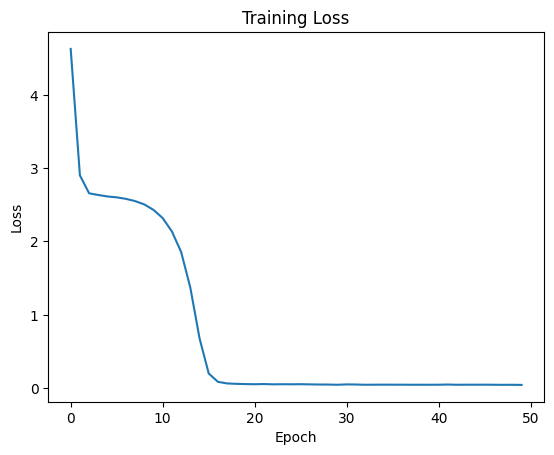

In [ ]:
epochs = list(range(len(history['loss'])))
plt.plot(epochs, history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

**Reflection**

Write your observations here

Loss dropped till 15(approx) epochs but then the loss became stagnant or is changing at a very slow rate.


# Inference

In [ ]:
eng, hin = next(iter(train_dataset))

idx = -5
actual_seq = detokenize(hin[idx], tgt_lang.idx2word)
translation, att_wgts = predict_seq2seq(encoder, decoder, eng[idx], tgt_lang, max_length_tgt)

eng_sent = detokenize(eng[idx], inp_lang.idx2word)
print(f'English Sentence:      {eng_sent}')
print(f'\nPredicted Translation: {translation}')
print(f'Actual Translation:    {actual_seq}')

English Sentence:      bythewayhaveyoueverbeentohokkaido

Predicted Translation: वैसेतुमकभीहोक्काईदोगईहुईहोक्या
Actual Translation:    वैसेतुमकभीहोक्काईदोगईहुईहोक्या


**Reflection**

Write your observations here

Predicted and actual translations are same which shows that model is working good!

## Visualizing attention weights

/courses/IE7374.202530/shared/genai-gpu/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning:

Layer 'attention_11' (of type Attention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.



English Sentence:      bythewayhaveyoueverbeentohokkaido
Predicted Translation: वैसेतुमकभीहोक्काईदोगईहुईहोक्या
Actual Translation:    वैसेतुमकभीहोक्काईदोगईहुईहोक्या


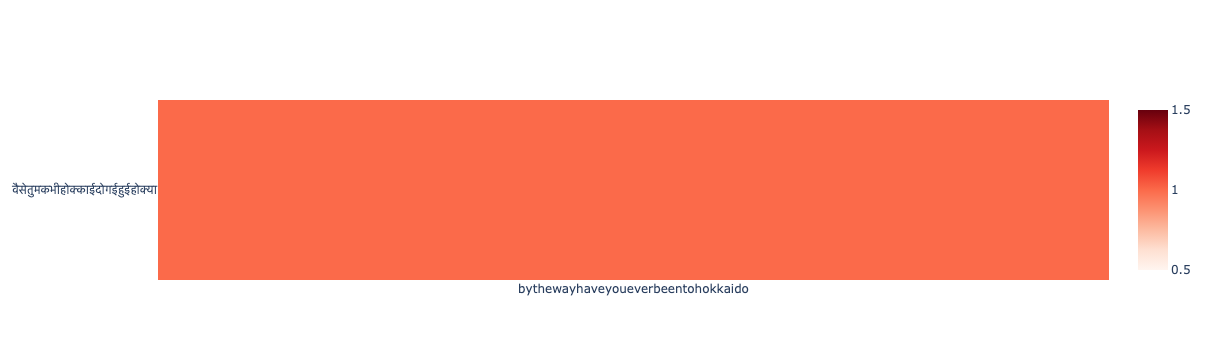

In [ ]:
import plotly
from plotly.offline import init_notebook_mode, iplot
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objects as go


idx = -5
actual_seq = detokenize(hin[idx], tgt_lang.idx2word)
translation, att_wgts = predict_seq2seq(encoder, decoder, eng[idx], tgt_lang, max_length_tgt)

eng_sent = detokenize(eng[idx], inp_lang.idx2word)
print(f'English Sentence:      {eng_sent}')
print(f'Predicted Translation: {translation}')
print(f'Actual Translation:    {actual_seq}')


eng_tokens = eng_sent.strip().split(' ')
eng_tokens += ['<PAD>'] * (max_length_inp - len(eng_tokens))

trace = go.Heatmap(
    z=att_wgts, 
    x= eng_tokens, 
    y=translation.split(' '), 
    colorscale='Reds'
)
iplot([trace])

**Reflection**

Write your observations here

attention weights seems to be distributed uniformly with value around 1.